Step 2: Dataset shape (rows, columns) = (7160831, 46)
Step 3: Feature matrix shape = (7160831, 45)
Step 3: Number of classes = 19
Step 4: After train/test split -
       X_train shape = (5728664, 45) y_train shape = (5728664,)
       X_test  shape = (1432167, 45) y_test  shape = (1432167,)
Step 4: ADASYN Resampled class distribution:
 label
5     1308765
2     1229981
4      643572
3      641569
9      453560
7      353522
6      333033
8      304307
1      154186
10     138429
17      67185
13      35501
11      22098
15      13466
0       12838
12      10218
16      10012
18       9660
14       4104
Name: count, dtype: int64
Step 4: Resampled dataset shape = (5746006, 45)
Step 5: Created federated data with 5 clients.
Step 6: Prepared federated data (list of batched tf.data.Datasets).

       Federated learning start         
Round 1, Metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([

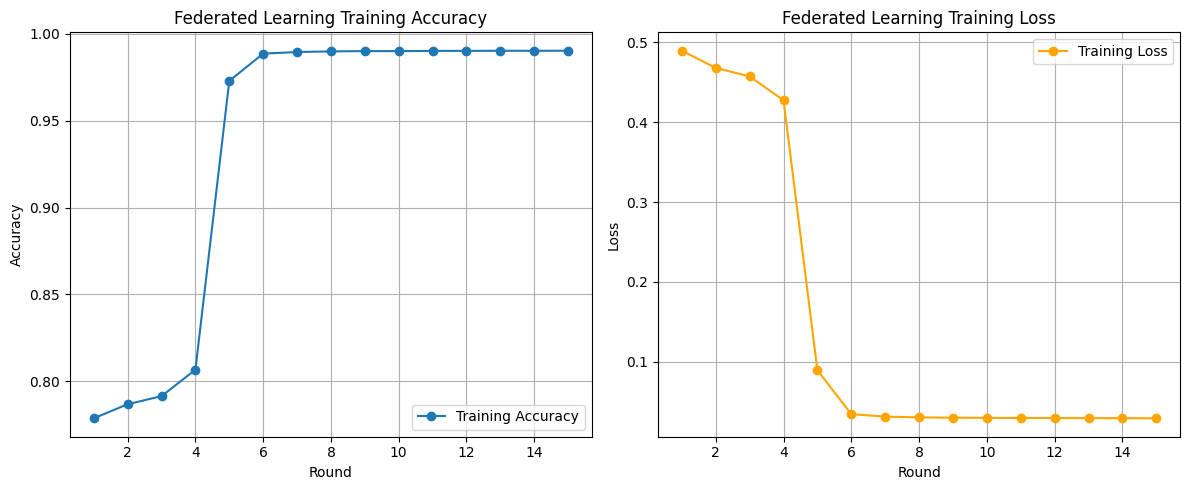

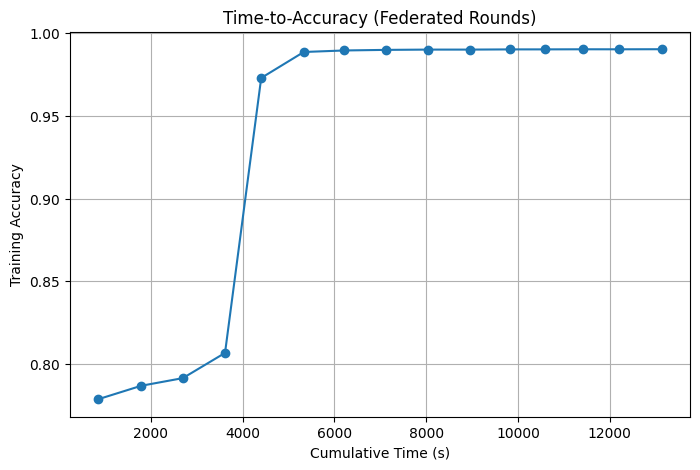


Per-Client Federated Test Metrics:
Client 1 => OrderedDict([('sparse_categorical_accuracy', 0.99243104), ('loss', 0.021832505)])
Client 2 => OrderedDict([('sparse_categorical_accuracy', 0.9924275), ('loss', 0.021801433)])
Client 3 => OrderedDict([('sparse_categorical_accuracy', 0.9927034), ('loss', 0.021560213)])
Client 4 => OrderedDict([('sparse_categorical_accuracy', 0.99282557), ('loss', 0.021177517)])
Client 5 => OrderedDict([('sparse_categorical_accuracy', 0.9929408), ('loss', 0.02094508)])

========== Classification Report (Local) ==========
                          precision    recall  f1-score   support

            ARP_Spoofing       0.61      0.55      0.58      3209
                  Benign       0.94      0.96      0.95     38546
               DDoS-ICMP       1.00      1.00      1.00    307495
                DDoS-SYN       1.00      1.00      1.00    160393
                DDoS-TCP       1.00      1.00      1.00    160893
                DDoS-UDP       1.00      1.00   

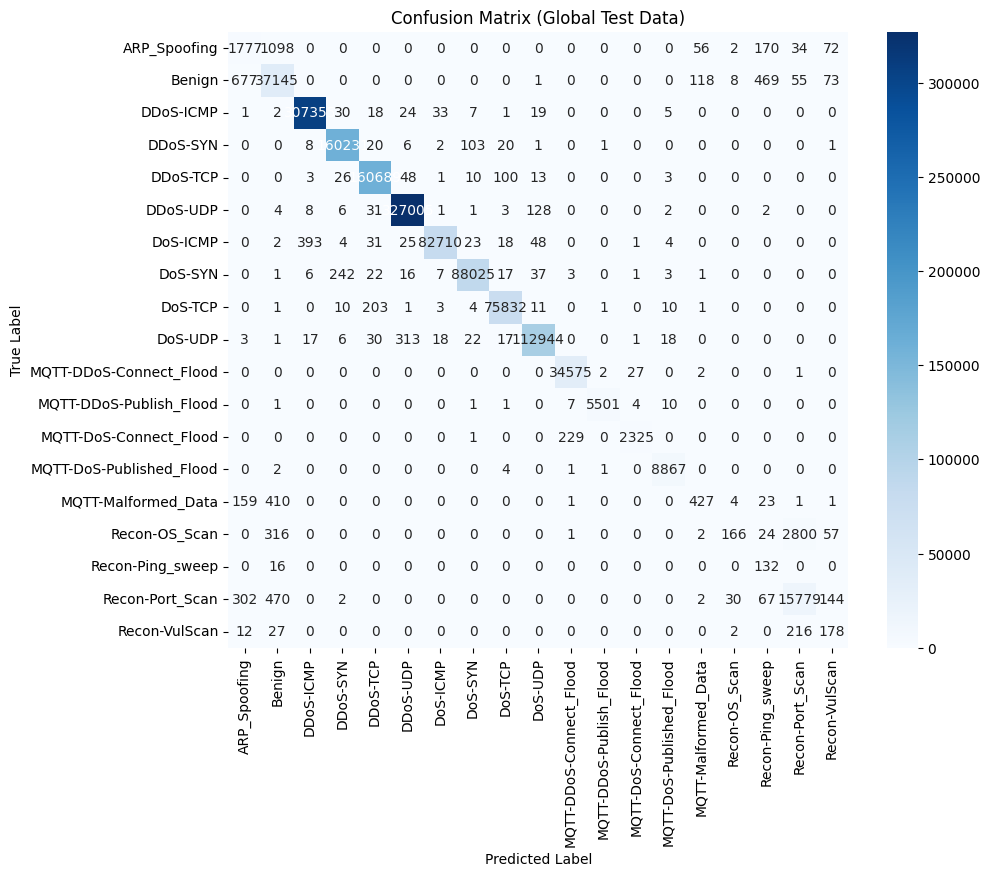

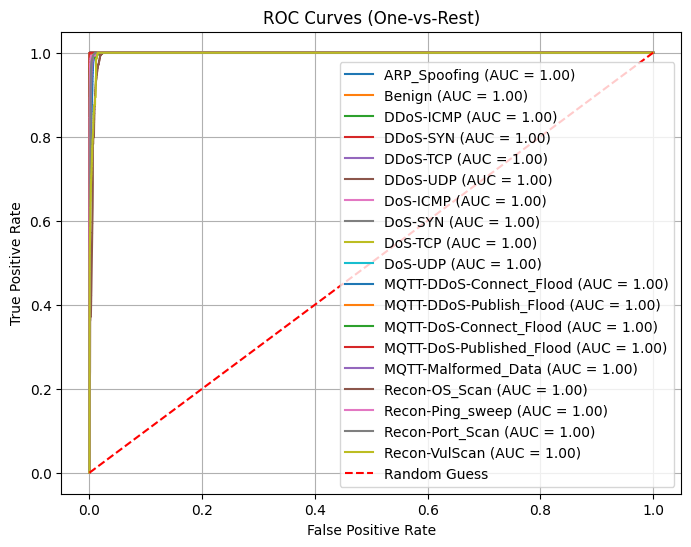


========== All Done! ==========

========== STEP 14: Additional Visualizations ==========


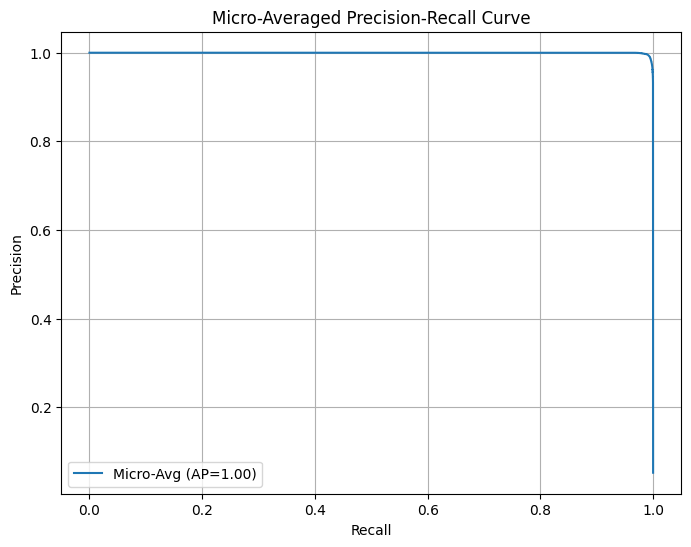

Micro-AP: 1.00, Approx Macro-AP: 0.86

========== Client-Specific Confusion Matrices ==========


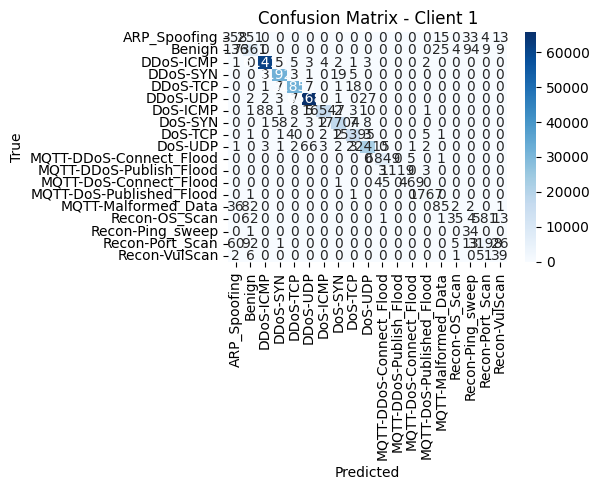

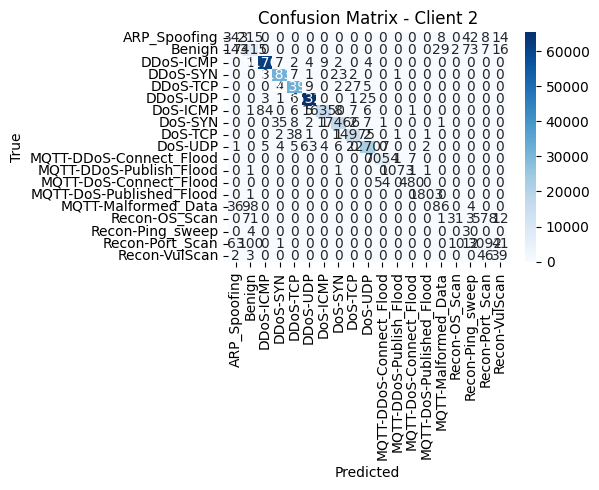

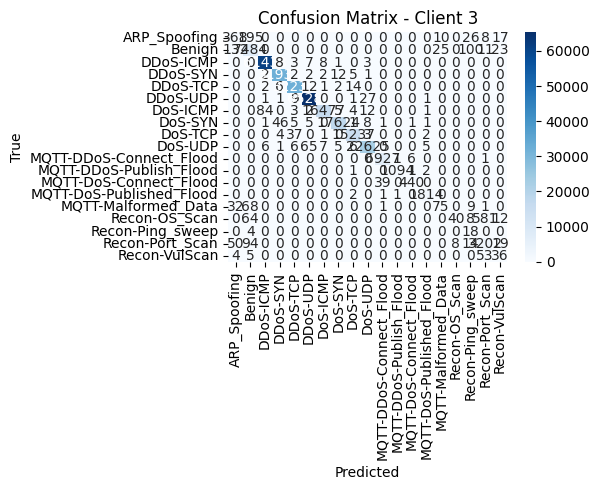

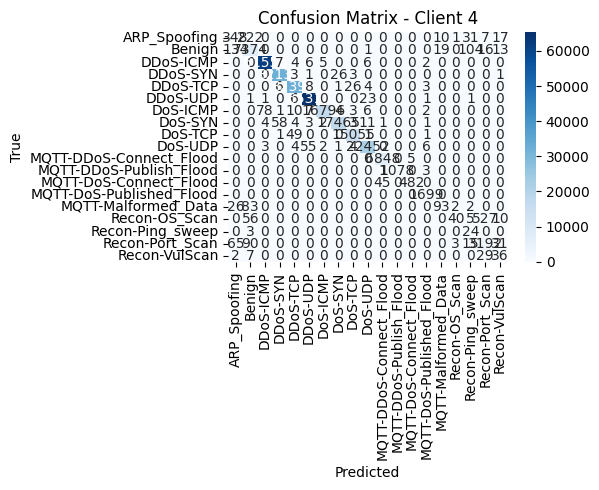

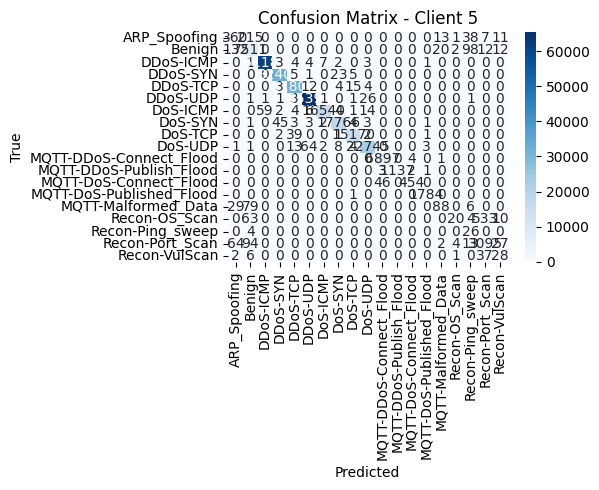


========== Additional Visualizations Complete! ==========


In [1]:
###############################################################################
# STEP 1: IMPORTS AND ENVIRONMENT SETUP
###############################################################################
import os
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

from imblearn.over_sampling import ADASYN

import nest_asyncio
nest_asyncio.apply()  # For notebook/interactive environments
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time  # For time-to-accuracy tracking

import tensorflow as tf
import tensorflow_federated as tff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_score, 
    recall_score, 
    f1_score,
    precision_recall_curve,
    average_precision_score
)
from tensorflow.keras.utils import to_categorical

###############################################################################
# STEP 2: LOAD AND LABEL THE DATASET
###############################################################################
def read_and_label_csv_files(root_dir):
    dataframes = []
    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_path, file_name)
                    df = pd.read_csv(file_path)
                    df['label'] = class_dir
                    dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

root_directory = "dataset"
merged_df = read_and_label_csv_files(root_directory)
print("Step 2: Dataset shape (rows, columns) =", merged_df.shape)
# Optional: Uncomment if you want to see the first few rows
# merged_df.head()

###############################################################################
# STEP 3: ENCODE LABELS AND SELECT FEATURES
###############################################################################
label_encoder = LabelEncoder()
merged_df['label'] = label_encoder.fit_transform(merged_df['label'])
merged_df['label'] = merged_df['label'].astype(int)

X = merged_df.drop(columns=['label'])
y = merged_df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Step 3: Feature matrix shape =", X_scaled.shape)
print("Step 3: Number of classes =", len(np.unique(y)))

###############################################################################
# STEP 4: TRAIN/TEST SPLIT AND APPLY ADASYN
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
print("Step 4: After train/test split -")
print("       X_train shape =", X_train.shape, "y_train shape =", y_train.shape)
print("       X_test  shape =", X_test.shape,  "y_test  shape =", y_test.shape)

adasyn_classes = [16, 18]  # Minority classes
adasyn = ADASYN(sampling_strategy={c: 10000 for c in adasyn_classes}, random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
print("Step 4: ADASYN Resampled class distribution:\n", pd.Series(y_resampled).value_counts())
print("Step 4: Resampled dataset shape =", X_resampled.shape)

y_onehot = to_categorical(y_resampled)

###############################################################################
# STEP 5: CREATE FEDERATED DATA
###############################################################################
def create_federated_data(X, y, num_clients):
    combined = list(zip(X, y))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    federated_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
        client_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        federated_data.append(client_data)
    return federated_data

num_clients = 5
federated_data = create_federated_data(X_resampled, y_resampled, num_clients)
print("Step 5: Created federated data with", num_clients, "clients.")

###############################################################################
# STEP 6: PREPROCESS FEDERATED DATA FOR TRAINING
###############################################################################
def preprocess_federated_data(client_data):
    def map_fn(x, y):
        return (
            tf.cast(tf.reshape(x, (-1, X.shape[1], 1)), tf.float32),
            y
        )
    dataset = tf.data.Dataset.from_tensor_slices((client_data["X"], client_data["y"]))
    return dataset.batch(32).map(map_fn)

federated_train_data = [preprocess_federated_data(cd) for cd in federated_data]
print("Step 6: Prepared federated data (list of batched tf.data.Datasets).")

###############################################################################
# STEP 7: DEFINE THE MODEL (SELF-ATTENTION + CNN) - NO CHANGE IN LAYERS
###############################################################################
def build_self_attention_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    attention_scores = tf.keras.layers.Dense(input_shape[0], activation="softmax", name="attention")(inputs)
    attention_output = tf.keras.layers.Multiply()([inputs, attention_scores])

    x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(attention_output)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

###############################################################################
# STEP 8: TFF MODEL FUNCTION + FEDERATED AVERAGING PROCESS
###############################################################################
def model_fn():
    keras_model = build_self_attention_cnn((X.shape[1], 1), len(np.unique(y)))
    input_spec = (
        tf.TensorSpec(shape=(None, X.shape[1], 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
    return tff.learning.from_keras_model(
        keras_model=keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

iterative_process = tff.learning.build_federated_averaging_process(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

###############################################################################
# STEP 9: FEDERATED TRAINING (TIME-TO-ACCURACY ADDED)
###############################################################################
state = iterative_process.initialize()
NUM_ROUNDS = 15
round_metrics = []

time_per_round = []
acc_per_round = []
cumulative_time = 0.0

print("\n       Federated learning start         ")
for round_num in range(1, NUM_ROUNDS + 1):
    start_time = time.time()
    state, metrics = iterative_process.next(state, federated_train_data)
    end_time = time.time()

    round_duration = end_time - start_time
    cumulative_time += round_duration
    time_per_round.append(cumulative_time)

    round_metrics.append(metrics)
    train_acc = metrics['train']['sparse_categorical_accuracy']
    train_loss = metrics['train']['loss']
    acc_per_round.append(train_acc)

    print(f"Round {round_num}, Metrics: {metrics}, Round Duration: {round_duration:.2f}s")

###############################################################################
# STEP 10: TEST DATA PREPARATION
###############################################################################
def evaluate_federated_model(state, federated_test_data):
    evaluation = tff.learning.build_federated_evaluation(model_fn)
    return evaluation(state.model, federated_test_data)

federated_test_data = [preprocess_federated_data({"X": X_test, "y": y_test})]
evaluation_metrics = evaluate_federated_model(state, federated_test_data)
print("\nFederated Evaluation Metrics:", evaluation_metrics)

###############################################################################
# STEP 11: TRAINING ACCURACY/LOSS PLOTS + TIME-TO-ACCURACY
###############################################################################
round_accuracies = [m['train']['sparse_categorical_accuracy'] for m in round_metrics]
round_losses = [m['train']['loss'] for m in round_metrics]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_ROUNDS + 1), round_accuracies, marker='o', label='Training Accuracy')
plt.title('Federated Learning Training Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_ROUNDS + 1), round_losses, marker='o', color='orange', label='Training Loss')
plt.title('Federated Learning Training Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Time-to-Accuracy Plot
plt.figure(figsize=(8,5))
plt.plot(time_per_round, acc_per_round, marker='o')
plt.title("Time-to-Accuracy (Federated Rounds)")
plt.xlabel("Cumulative Time (s)")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()

###############################################################################
# STEP 12: PER-CLIENT FEDERATED EVALUATION
###############################################################################
def prepare_test_data_for_each_client(X_test, y_test, num_clients):
    combined = list(zip(X_test, y_test))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    client_test_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
        c_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        client_test_data.append(c_data)
    return client_test_data

client_test_data = prepare_test_data_for_each_client(X_test, y_test, num_clients)
federated_test_data_by_client = [preprocess_federated_data(d) for d in client_test_data]

eval_comp = tff.learning.build_federated_evaluation(model_fn)
print("\nPer-Client Federated Test Metrics:")
client_scores = []
for i, test_dataset in enumerate(federated_test_data_by_client, start=1):
    metrics_i = eval_comp(state.model, [test_dataset])
    client_scores.append(metrics_i)
    print(f"Client {i} => {metrics_i}")

###############################################################################
# STEP 13: LOCAL EVALUATION (CLASSIFICATION REPORT, CONFUSION MATRIX, ETC.)
###############################################################################
def assign_tff_weights_to_keras(keras_model, tff_state_model):
    keras_model.set_weights([np.array(w) for w in tff_state_model.trainable])

local_keras_model = build_self_attention_cnn(
    input_shape=(X.shape[1], 1),
    num_classes=len(np.unique(y))
)
assign_tff_weights_to_keras(local_keras_model, state.model)
local_keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Full test set predictions (local)
y_pred_probs = local_keras_model.predict(np.expand_dims(X_test, axis=-1))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\n========== Classification Report (Local) ==========")
actual_class_names = label_encoder.classes_
print(classification_report(y_test, y_pred_classes, target_names=actual_class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=actual_class_names,
    yticklabels=actual_class_names
)
plt.title("Confusion Matrix (Global Test Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curves (One-vs-Rest)
num_classes = len(np.unique(y))
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_dict[i] = fpr
    tpr_dict[i] = tpr
    roc_auc_dict[i] = roc_auc

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_dict[i], tpr_dict[i], label=f"{actual_class_names[i]} (AUC = {roc_auc_dict[i]:.2f})")

plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("\n========== All Done! ==========")

###############################################################################
# STEP 14: ADDITIONAL VISUALIZATIONS (MICRO/MACRO PR, CLIENT-SPECIFIC CONFUSION)
###############################################################################
print("\n========== STEP 14: Additional Visualizations ==========")

# 14.1 Micro/Macro PR Curves
precision_micro, recall_micro, _ = precision_recall_curve(y_test_onehot.ravel(), y_pred_probs.ravel())
ap_micro = average_precision_score(y_test_onehot.ravel(), y_pred_probs.ravel())

ap_macro = 0
for i in range(num_classes):
    ap_macro += average_precision_score(y_test_onehot[:, i], y_pred_probs[:, i])
ap_macro /= num_classes

plt.figure(figsize=(8, 6))
plt.plot(recall_micro, precision_micro, label=f"Micro-Avg (AP={ap_micro:.2f})")
plt.title("Micro-Averaged Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()

print(f"Micro-AP: {ap_micro:.2f}, Approx Macro-AP: {ap_macro:.2f}")

# 14.2 Client-Specific Confusion Matrices
def plot_client_confusion_matrices(local_model, client_test_data, label_names):
    for i, c_data in enumerate(client_test_data, start=1):
        y_pred_c = local_model.predict(np.expand_dims(c_data["X"], axis=-1))
        y_pred_classes_c = np.argmax(y_pred_c, axis=1)
        c_mat = confusion_matrix(c_data["y"], y_pred_classes_c)

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            c_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names
        )
        plt.title(f"Confusion Matrix - Client {i}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
    

print("\n========== Client-Specific Confusion Matrices ==========")
plot_client_confusion_matrices(local_keras_model, client_test_data, actual_class_names)

print("\n========== Additional Visualizations Complete! ==========")


RMSPROP

Step 2: Dataset shape (rows, columns) = (7160831, 46)
Step 3: Feature matrix shape = (7160831, 45)
Step 3: Number of classes = 19
Step 4: After train/test split -
       X_train shape = (5728664, 45) y_train shape = (5728664,)
       X_test  shape = (1432167, 45) y_test  shape = (1432167,)
Step 4: ADASYN Resampled class distribution:
 label
5     1308765
2     1229981
4      643572
3      641569
9      453560
7      353522
6      333033
8      304307
1      154186
10     138429
17      67185
13      35501
11      22098
15      13466
0       12838
12      10218
16      10012
18       9660
14       4104
Name: count, dtype: int64
Step 4: Resampled dataset shape = (5746006, 45)
Step 5: Created federated data with 5 clients.
Step 6: Prepared federated data (list of batched tf.data.Datasets).

       Federated learning start         
Round 1, Metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([

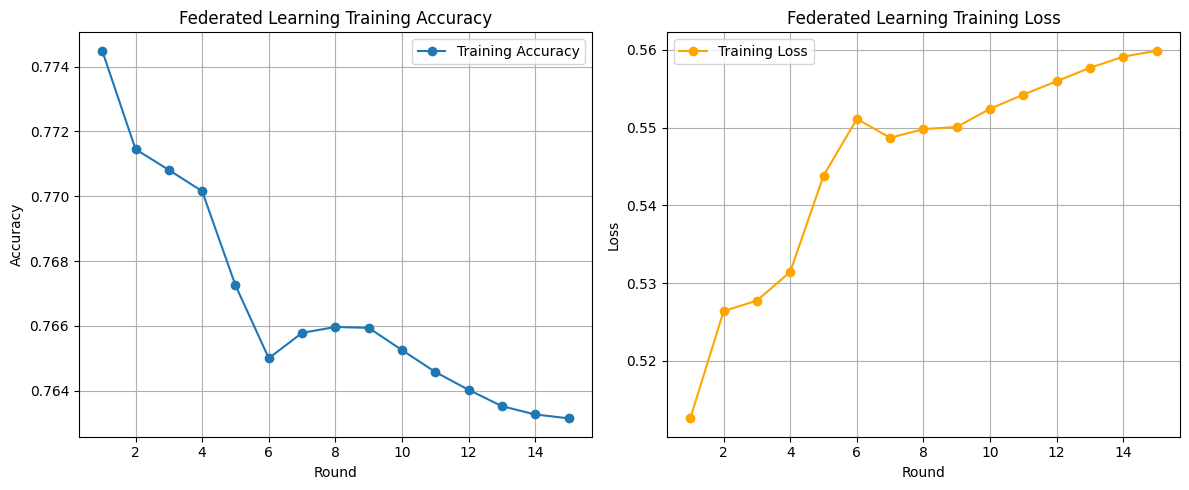

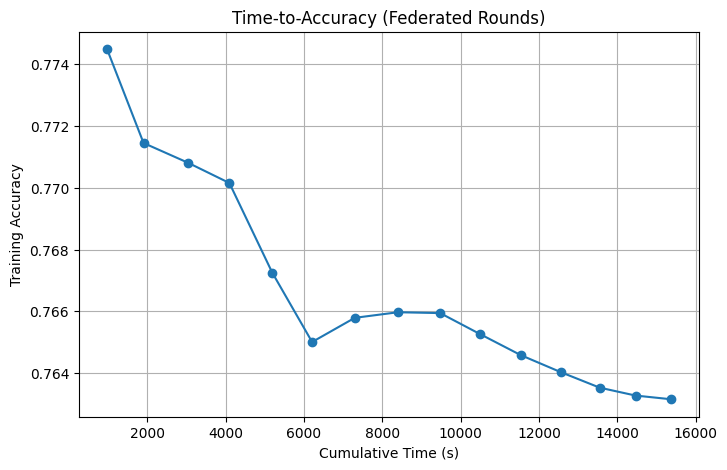


Per-Client Federated Test Metrics:
Client 1 => OrderedDict([('sparse_categorical_accuracy', 0.7739262), ('loss', 0.5117788)])
Client 2 => OrderedDict([('sparse_categorical_accuracy', 0.77553564), ('loss', 0.5122198)])
Client 3 => OrderedDict([('sparse_categorical_accuracy', 0.77550423), ('loss', 0.5126781)])
Client 4 => OrderedDict([('sparse_categorical_accuracy', 0.77314067), ('loss', 0.5135855)])
Client 5 => OrderedDict([('sparse_categorical_accuracy', 0.7737148), ('loss', 0.5137427)])

========== Classification Report (Local) ==========
                          precision    recall  f1-score   support

            ARP_Spoofing       0.52      0.02      0.04      3209
                  Benign       0.83      0.98      0.90     38546
               DDoS-ICMP       0.79      0.99      0.88    307495
                DDoS-SYN       0.80      0.90      0.85    160393
                DDoS-TCP       0.68      0.99      0.81    160893
                DDoS-UDP       0.78      0.98      0.87 

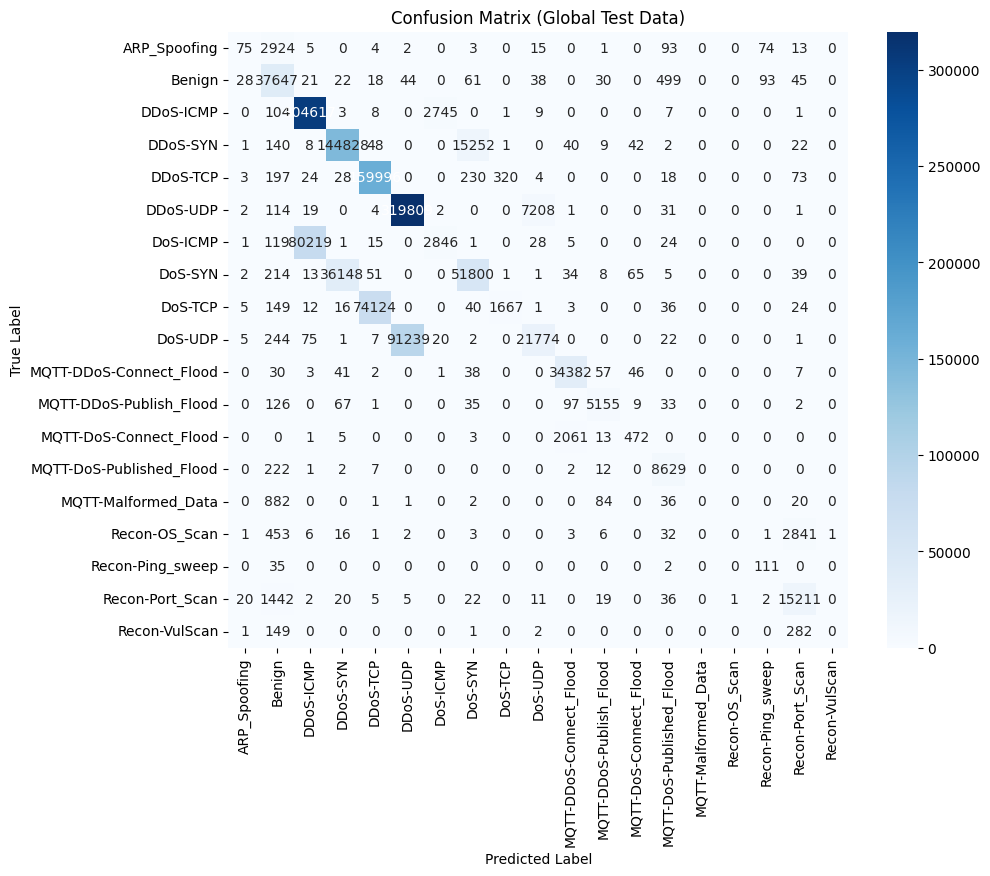

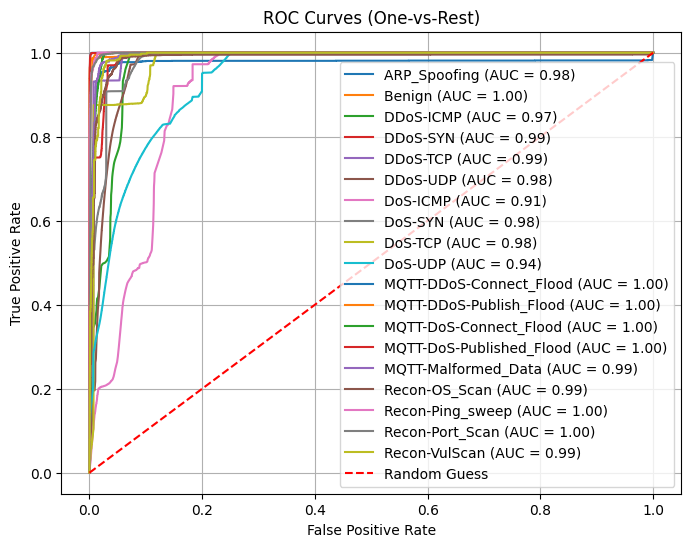


========== All Done! ==========

========== STEP 14: Additional Visualizations ==========


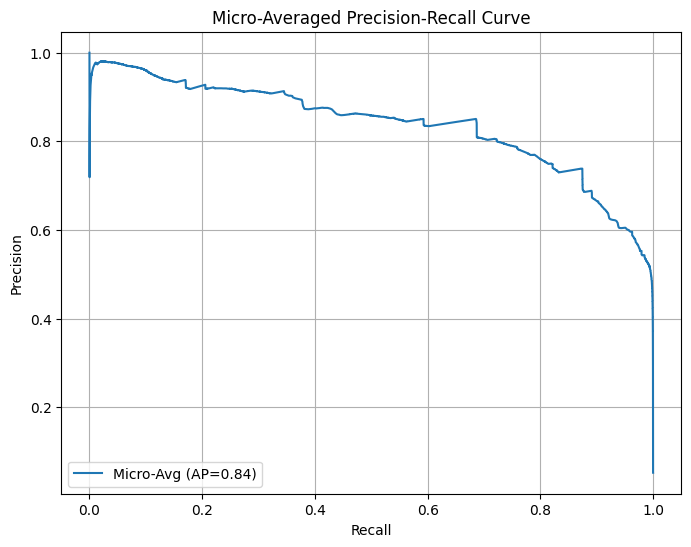

Micro-AP: 0.84, Approx Macro-AP: 0.64

========== Client-Specific Confusion Matrices ==========


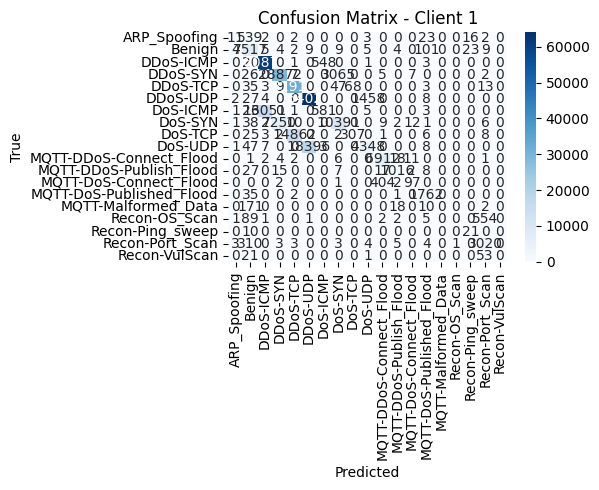

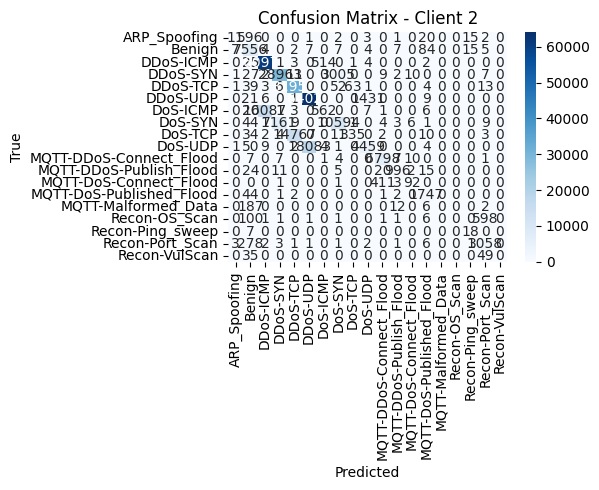

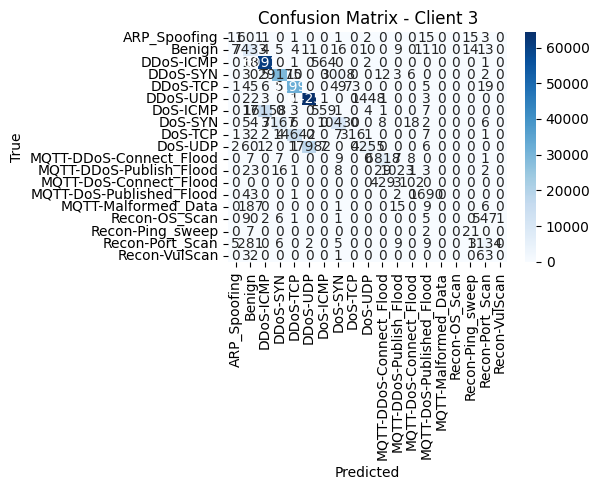

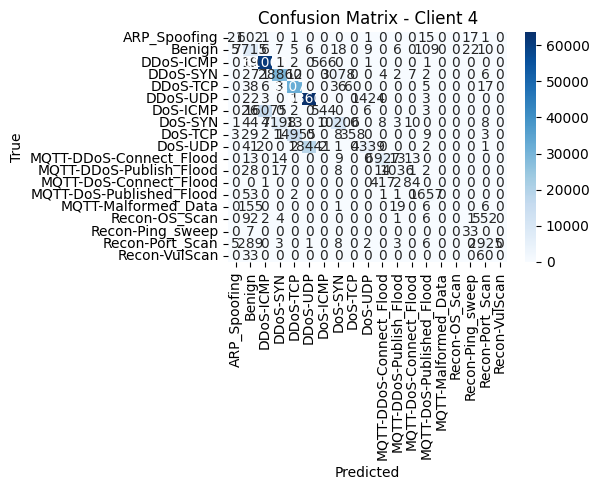

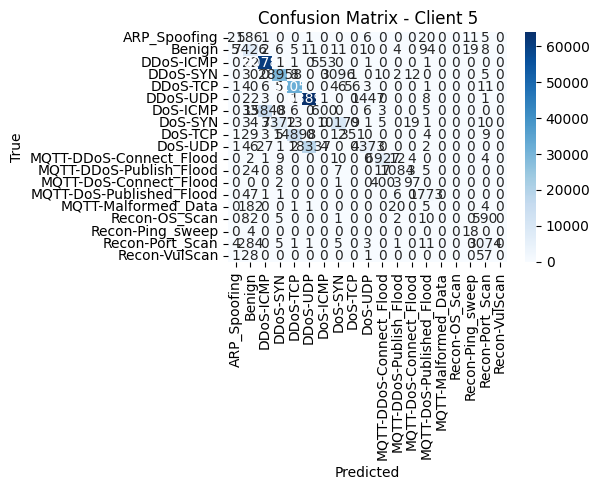


========== Additional Visualizations Complete! ==========


In [2]:
###############################################################################
# STEP 1: IMPORTS AND ENVIRONMENT SETUP
###############################################################################
import os
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

from imblearn.over_sampling import ADASYN

import nest_asyncio
nest_asyncio.apply()  # For notebook/interactive environments
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time  # For time-to-accuracy tracking

import tensorflow as tf
import tensorflow_federated as tff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_score, 
    recall_score, 
    f1_score,
    precision_recall_curve,
    average_precision_score
)
from tensorflow.keras.utils import to_categorical

###############################################################################
# STEP 2: LOAD AND LABEL THE DATASET
###############################################################################
def read_and_label_csv_files(root_dir):
    dataframes = []
    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_path, file_name)
                    df = pd.read_csv(file_path)
                    df['label'] = class_dir
                    dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

root_directory = "dataset"
merged_df = read_and_label_csv_files(root_directory)
print("Step 2: Dataset shape (rows, columns) =", merged_df.shape)
# Optional: Uncomment if you want to see the first few rows
# merged_df.head()

###############################################################################
# STEP 3: ENCODE LABELS AND SELECT FEATURES
###############################################################################
label_encoder = LabelEncoder()
merged_df['label'] = label_encoder.fit_transform(merged_df['label'])
merged_df['label'] = merged_df['label'].astype(int)

X = merged_df.drop(columns=['label'])
y = merged_df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Step 3: Feature matrix shape =", X_scaled.shape)
print("Step 3: Number of classes =", len(np.unique(y)))

###############################################################################
# STEP 4: TRAIN/TEST SPLIT AND APPLY ADASYN
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
print("Step 4: After train/test split -")
print("       X_train shape =", X_train.shape, "y_train shape =", y_train.shape)
print("       X_test  shape =", X_test.shape,  "y_test  shape =", y_test.shape)

adasyn_classes = [16, 18]  # Minority classes
adasyn = ADASYN(sampling_strategy={c: 10000 for c in adasyn_classes}, random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
print("Step 4: ADASYN Resampled class distribution:\n", pd.Series(y_resampled).value_counts())
print("Step 4: Resampled dataset shape =", X_resampled.shape)

y_onehot = to_categorical(y_resampled)

###############################################################################
# STEP 5: CREATE FEDERATED DATA
###############################################################################
def create_federated_data(X, y, num_clients):
    combined = list(zip(X, y))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    federated_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
        client_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        federated_data.append(client_data)
    return federated_data

num_clients = 5
federated_data = create_federated_data(X_resampled, y_resampled, num_clients)
print("Step 5: Created federated data with", num_clients, "clients.")

###############################################################################
# STEP 6: PREPROCESS FEDERATED DATA FOR TRAINING
###############################################################################
def preprocess_federated_data(client_data):
    def map_fn(x, y):
        return (
            tf.cast(tf.reshape(x, (-1, X.shape[1], 1)), tf.float32),
            y
        )
    dataset = tf.data.Dataset.from_tensor_slices((client_data["X"], client_data["y"]))
    return dataset.batch(32).map(map_fn)

federated_train_data = [preprocess_federated_data(cd) for cd in federated_data]
print("Step 6: Prepared federated data (list of batched tf.data.Datasets).")

###############################################################################
# STEP 7: DEFINE THE MODEL (SELF-ATTENTION + CNN) - NO CHANGE IN LAYERS
###############################################################################
def build_self_attention_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    attention_scores = tf.keras.layers.Dense(input_shape[0], activation="softmax", name="attention")(inputs)
    attention_output = tf.keras.layers.Multiply()([inputs, attention_scores])

    x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(attention_output)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

###############################################################################
# STEP 8: TFF MODEL FUNCTION + FEDERATED AVERAGING PROCESS
###############################################################################
def model_fn():
    keras_model = build_self_attention_cnn((X.shape[1], 1), len(np.unique(y)))
    input_spec = (
        tf.TensorSpec(shape=(None, X.shape[1], 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
    return tff.learning.from_keras_model(
        keras_model=keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

iterative_process = tff.learning.build_federated_averaging_process(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.RMSprop(
        learning_rate=0.001, rho=0.9, epsilon=1e-07
    ),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

###############################################################################
# STEP 9: FEDERATED TRAINING (TIME-TO-ACCURACY ADDED)
###############################################################################
state = iterative_process.initialize()
NUM_ROUNDS = 15
round_metrics = []

time_per_round = []
acc_per_round = []
cumulative_time = 0.0

print("\n       Federated learning start         ")
for round_num in range(1, NUM_ROUNDS + 1):
    start_time = time.time()
    state, metrics = iterative_process.next(state, federated_train_data)
    end_time = time.time()

    round_duration = end_time - start_time
    cumulative_time += round_duration
    time_per_round.append(cumulative_time)

    round_metrics.append(metrics)
    train_acc = metrics['train']['sparse_categorical_accuracy']
    train_loss = metrics['train']['loss']
    acc_per_round.append(train_acc)

    print(f"Round {round_num}, Metrics: {metrics}, Round Duration: {round_duration:.2f}s")

###############################################################################
# STEP 10: TEST DATA PREPARATION
###############################################################################
def evaluate_federated_model(state, federated_test_data):
    evaluation = tff.learning.build_federated_evaluation(model_fn)
    return evaluation(state.model, federated_test_data)

federated_test_data = [preprocess_federated_data({"X": X_test, "y": y_test})]
evaluation_metrics = evaluate_federated_model(state, federated_test_data)
print("\nFederated Evaluation Metrics:", evaluation_metrics)

###############################################################################
# STEP 11: TRAINING ACCURACY/LOSS PLOTS + TIME-TO-ACCURACY
###############################################################################
round_accuracies = [m['train']['sparse_categorical_accuracy'] for m in round_metrics]
round_losses = [m['train']['loss'] for m in round_metrics]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_ROUNDS + 1), round_accuracies, marker='o', label='Training Accuracy')
plt.title('Federated Learning Training Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_ROUNDS + 1), round_losses, marker='o', color='orange', label='Training Loss')
plt.title('Federated Learning Training Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Time-to-Accuracy Plot
plt.figure(figsize=(8,5))
plt.plot(time_per_round, acc_per_round, marker='o')
plt.title("Time-to-Accuracy (Federated Rounds)")
plt.xlabel("Cumulative Time (s)")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()

###############################################################################
# STEP 12: PER-CLIENT FEDERATED EVALUATION
###############################################################################
def prepare_test_data_for_each_client(X_test, y_test, num_clients):
    combined = list(zip(X_test, y_test))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    client_test_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
        c_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        client_test_data.append(c_data)
    return client_test_data

client_test_data = prepare_test_data_for_each_client(X_test, y_test, num_clients)
federated_test_data_by_client = [preprocess_federated_data(d) for d in client_test_data]

eval_comp = tff.learning.build_federated_evaluation(model_fn)
print("\nPer-Client Federated Test Metrics:")
client_scores = []
for i, test_dataset in enumerate(federated_test_data_by_client, start=1):
    metrics_i = eval_comp(state.model, [test_dataset])
    client_scores.append(metrics_i)
    print(f"Client {i} => {metrics_i}")

###############################################################################
# STEP 13: LOCAL EVALUATION (CLASSIFICATION REPORT, CONFUSION MATRIX, ETC.)
###############################################################################
def assign_tff_weights_to_keras(keras_model, tff_state_model):
    keras_model.set_weights([np.array(w) for w in tff_state_model.trainable])

local_keras_model = build_self_attention_cnn(
    input_shape=(X.shape[1], 1),
    num_classes=len(np.unique(y))
)
assign_tff_weights_to_keras(local_keras_model, state.model)
local_keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Full test set predictions (local)
y_pred_probs = local_keras_model.predict(np.expand_dims(X_test, axis=-1))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\n========== Classification Report (Local) ==========")
actual_class_names = label_encoder.classes_
print(classification_report(y_test, y_pred_classes, target_names=actual_class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=actual_class_names,
    yticklabels=actual_class_names
)
plt.title("Confusion Matrix (Global Test Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curves (One-vs-Rest)
num_classes = len(np.unique(y))
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_dict[i] = fpr
    tpr_dict[i] = tpr
    roc_auc_dict[i] = roc_auc

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_dict[i], tpr_dict[i], label=f"{actual_class_names[i]} (AUC = {roc_auc_dict[i]:.2f})")

plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("\n========== All Done! ==========")

###############################################################################
# STEP 14: ADDITIONAL VISUALIZATIONS (MICRO/MACRO PR, CLIENT-SPECIFIC CONFUSION)
###############################################################################
print("\n========== STEP 14: Additional Visualizations ==========")

# 14.1 Micro/Macro PR Curves
precision_micro, recall_micro, _ = precision_recall_curve(y_test_onehot.ravel(), y_pred_probs.ravel())
ap_micro = average_precision_score(y_test_onehot.ravel(), y_pred_probs.ravel())

ap_macro = 0
for i in range(num_classes):
    ap_macro += average_precision_score(y_test_onehot[:, i], y_pred_probs[:, i])
ap_macro /= num_classes

plt.figure(figsize=(8, 6))
plt.plot(recall_micro, precision_micro, label=f"Micro-Avg (AP={ap_micro:.2f})")
plt.title("Micro-Averaged Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()

print(f"Micro-AP: {ap_micro:.2f}, Approx Macro-AP: {ap_macro:.2f}")

# 14.2 Client-Specific Confusion Matrices
def plot_client_confusion_matrices(local_model, client_test_data, label_names):
    for i, c_data in enumerate(client_test_data, start=1):
        y_pred_c = local_model.predict(np.expand_dims(c_data["X"], axis=-1))
        y_pred_classes_c = np.argmax(y_pred_c, axis=1)
        c_mat = confusion_matrix(c_data["y"], y_pred_classes_c)

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            c_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names
        )
        plt.title(f"Confusion Matrix - Client {i}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
    

print("\n========== Client-Specific Confusion Matrices ==========")
plot_client_confusion_matrices(local_keras_model, client_test_data, actual_class_names)

print("\n========== Additional Visualizations Complete! ==========")


## change

Step 2: Dataset shape (rows, columns) = (7160831, 46)
Step 3: Feature matrix shape = (7160831, 45)
Step 3: Number of classes = 19
Step 4: After train/test split -
       X_train shape = (5728664, 45) y_train shape = (5728664,)
       X_test  shape = (1432167, 45) y_test  shape = (1432167,)
Step 4: ADASYN Resampled class distribution:
 label
5     1308765
2     1229981
4      643572
3      641569
9      453560
7      353522
6      333033
8      304307
1      154186
10     138429
17      67185
13      35501
11      22098
15      13466
0       12838
12      10218
16      10012
18       9660
14       4104
Name: count, dtype: int64
Step 4: Resampled dataset shape = (5746006, 45)
Step 5: Created federated data with 5 clients.
Step 6: Prepared federated data (list of batched tf.data.Datasets).

       Federated learning start         
Round 1, Metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([

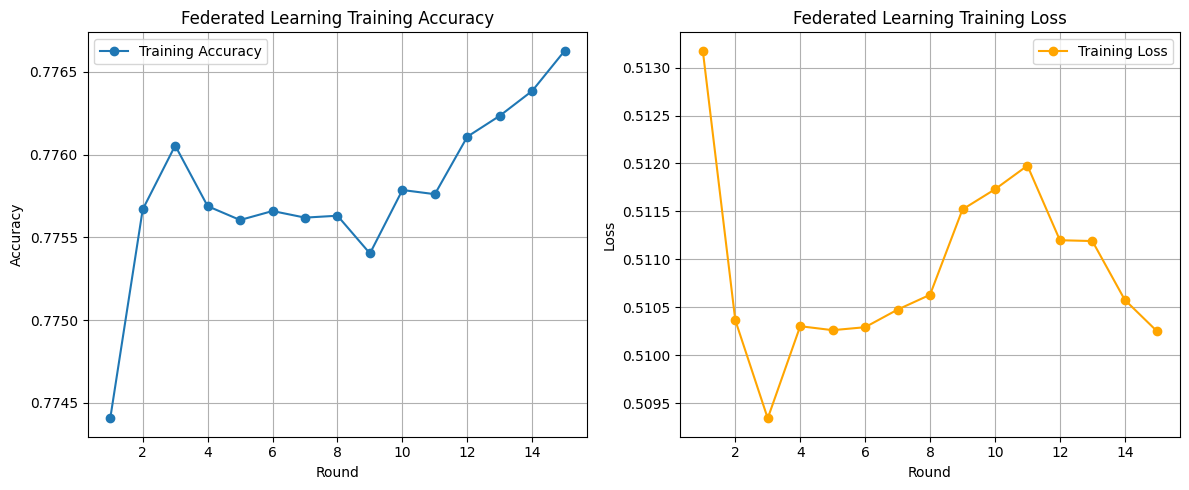

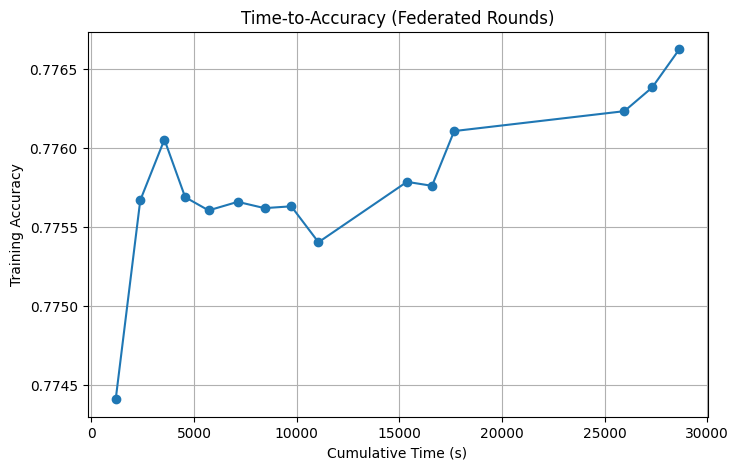


Per-Client Federated Test Metrics:
Client 1 => OrderedDict([('sparse_categorical_accuracy', 0.6936282), ('loss', 2.3665805)])
Client 2 => OrderedDict([('sparse_categorical_accuracy', 0.69332445), ('loss', 2.371997)])
Client 3 => OrderedDict([('sparse_categorical_accuracy', 0.6948745), ('loss', 2.354478)])
Client 4 => OrderedDict([('sparse_categorical_accuracy', 0.6939459), ('loss', 2.3671827)])
Client 5 => OrderedDict([('sparse_categorical_accuracy', 0.69382584), ('loss', 2.3691638)])

========== Classification Report (Local) ==========
                          precision    recall  f1-score   support

            ARP_Spoofing       0.00      0.00      0.00      3209
                  Benign       0.98      0.57      0.72     38546
               DDoS-ICMP       0.78      0.99      0.87    307495
                DDoS-SYN       0.55      0.99      0.71    160393
                DDoS-TCP       0.64      0.93      0.76    160893
                DDoS-UDP       0.74      0.94      0.83    

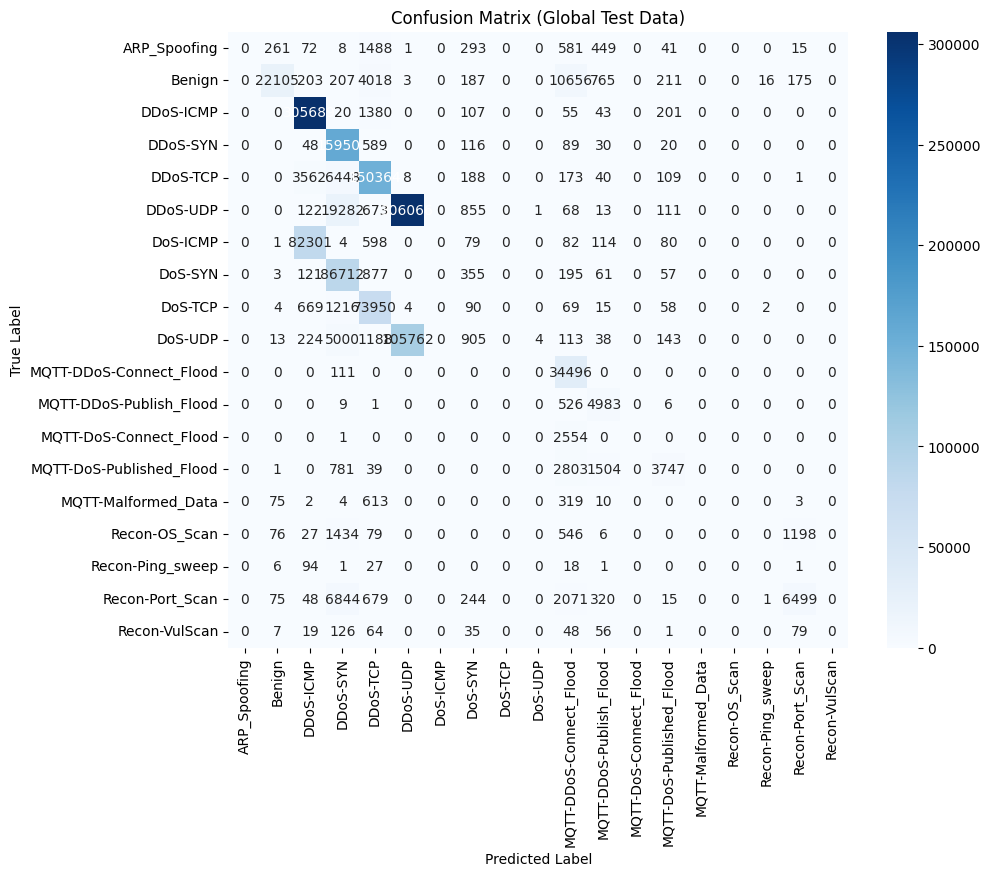

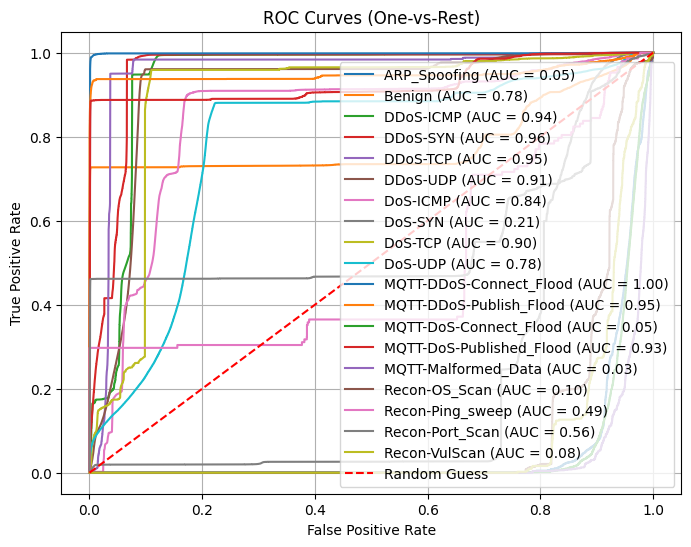


========== All Done! ==========

========== STEP 14: Additional Visualizations ==========


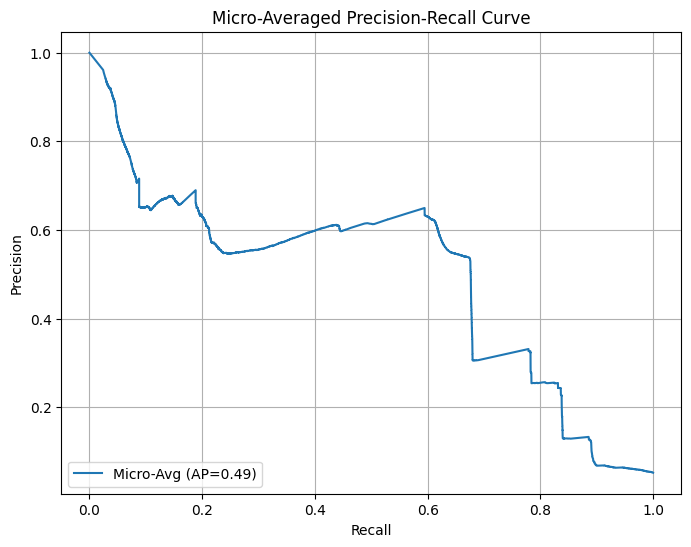

Micro-AP: 0.49, Approx Macro-AP: 0.37

========== Client-Specific Confusion Matrices ==========


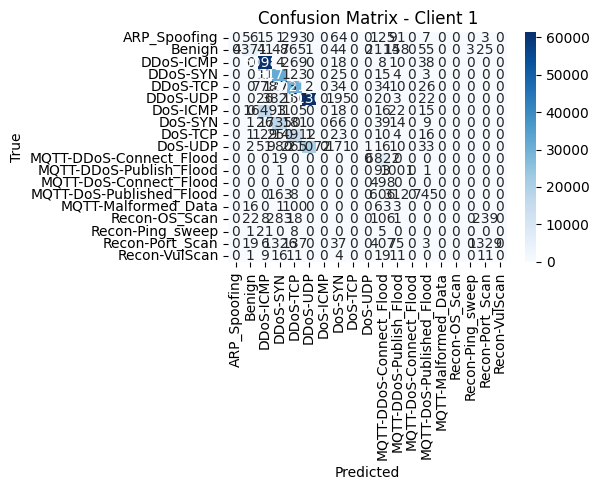

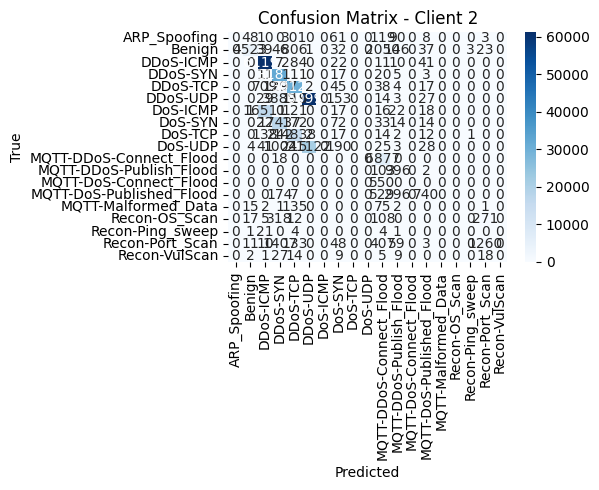

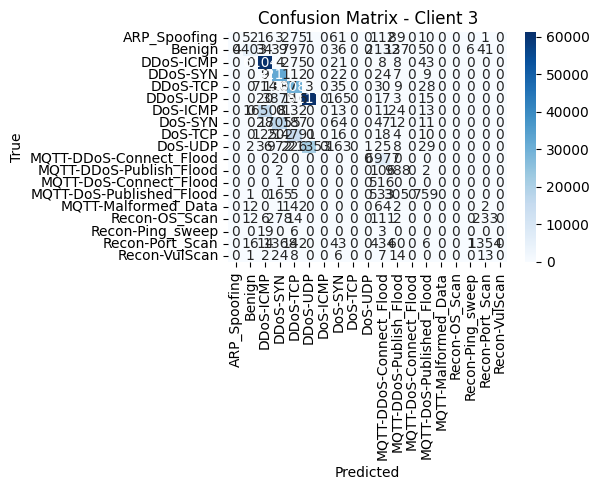

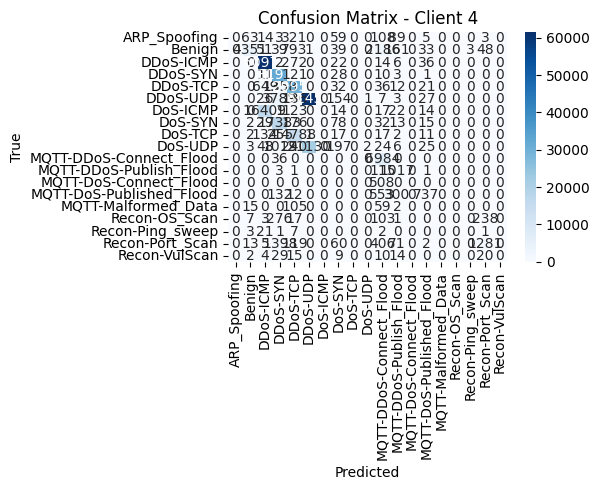

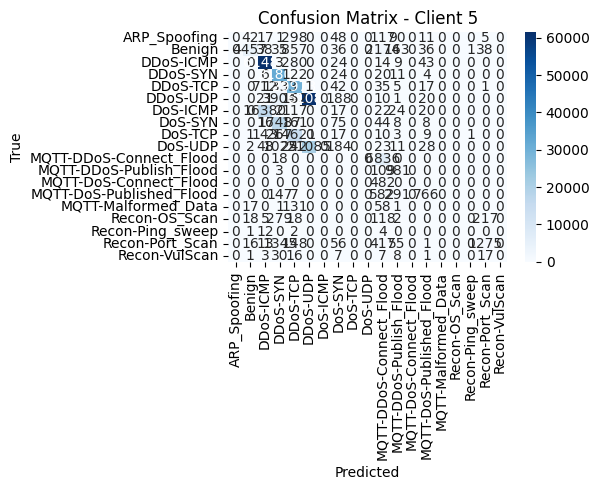


========== Additional Visualizations Complete! ==========


In [3]:
###############################################################################
# STEP 1: IMPORTS AND ENVIRONMENT SETUP
###############################################################################
import os
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

from imblearn.over_sampling import ADASYN

import nest_asyncio
nest_asyncio.apply()  # For notebook/interactive environments
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time  # For time-to-accuracy tracking

import tensorflow as tf
import tensorflow_federated as tff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_score, 
    recall_score, 
    f1_score,
    precision_recall_curve,
    average_precision_score
)
from tensorflow.keras.utils import to_categorical

###############################################################################
# STEP 2: LOAD AND LABEL THE DATASET
###############################################################################
def read_and_label_csv_files(root_dir):
    dataframes = []
    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_path, file_name)
                    df = pd.read_csv(file_path)
                    df['label'] = class_dir
                    dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

root_directory = "dataset"
merged_df = read_and_label_csv_files(root_directory)
print("Step 2: Dataset shape (rows, columns) =", merged_df.shape)
# Optional: Uncomment if you want to see the first few rows
# merged_df.head()

###############################################################################
# STEP 3: ENCODE LABELS AND SELECT FEATURES
###############################################################################
label_encoder = LabelEncoder()
merged_df['label'] = label_encoder.fit_transform(merged_df['label'])
merged_df['label'] = merged_df['label'].astype(int)

X = merged_df.drop(columns=['label'])
y = merged_df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Step 3: Feature matrix shape =", X_scaled.shape)
print("Step 3: Number of classes =", len(np.unique(y)))

###############################################################################
# STEP 4: TRAIN/TEST SPLIT AND APPLY ADASYN
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
print("Step 4: After train/test split -")
print("       X_train shape =", X_train.shape, "y_train shape =", y_train.shape)
print("       X_test  shape =", X_test.shape,  "y_test  shape =", y_test.shape)

adasyn_classes = [16, 18]  # Minority classes
adasyn = ADASYN(sampling_strategy={c: 10000 for c in adasyn_classes}, random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
print("Step 4: ADASYN Resampled class distribution:\n", pd.Series(y_resampled).value_counts())
print("Step 4: Resampled dataset shape =", X_resampled.shape)

y_onehot = to_categorical(y_resampled)

###############################################################################
# STEP 5: CREATE FEDERATED DATA
###############################################################################
def create_federated_data(X, y, num_clients):
    combined = list(zip(X, y))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    federated_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
        client_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        federated_data.append(client_data)
    return federated_data

num_clients = 5
federated_data = create_federated_data(X_resampled, y_resampled, num_clients)
print("Step 5: Created federated data with", num_clients, "clients.")

###############################################################################
# STEP 6: PREPROCESS FEDERATED DATA FOR TRAINING
###############################################################################
def preprocess_federated_data(client_data):
    def map_fn(x, y):
        return (
            tf.cast(tf.reshape(x, (-1, X.shape[1], 1)), tf.float32),
            y
        )
    dataset = tf.data.Dataset.from_tensor_slices((client_data["X"], client_data["y"]))
    return dataset.batch(32).map(map_fn)

federated_train_data = [preprocess_federated_data(cd) for cd in federated_data]
print("Step 6: Prepared federated data (list of batched tf.data.Datasets).")

###############################################################################
# STEP 7: DEFINE THE MODEL (SELF-ATTENTION + CNN) - NO CHANGE IN LAYERS
###############################################################################
def build_self_attention_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    attention_scores = tf.keras.layers.Dense(input_shape[0], activation="softmax", name="attention")(inputs)
    attention_output = tf.keras.layers.Multiply()([inputs, attention_scores])

    x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(attention_output)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

###############################################################################
# STEP 8: TFF MODEL FUNCTION + FEDERATED AVERAGING PROCESS (WITH NEW OPTIMIZERS)
###############################################################################
def model_fn():
    keras_model = build_self_attention_cnn((X.shape[1], 1), len(np.unique(y)))
    input_spec = (
        tf.TensorSpec(shape=(None, X.shape[1], 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
    return tff.learning.from_keras_model(
        keras_model=keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Change the client and server optimizers here:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn=model_fn,
    # Example client optimizer: RMSprop
    client_optimizer_fn=lambda: tf.keras.optimizers.RMSprop(learning_rate=0.001),
    # Example server optimizer: Adam
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.01),
)
###############################################################################
# STEP 9: FEDERATED TRAINING (TIME-TO-ACCURACY ADDED)
###############################################################################
state = iterative_process.initialize()
NUM_ROUNDS = 15
round_metrics = []

time_per_round = []
acc_per_round = []
cumulative_time = 0.0

print("\n       Federated learning start         ")
for round_num in range(1, NUM_ROUNDS + 1):
    start_time = time.time()
    state, metrics = iterative_process.next(state, federated_train_data)
    end_time = time.time()

    round_duration = end_time - start_time
    cumulative_time += round_duration
    time_per_round.append(cumulative_time)

    round_metrics.append(metrics)
    train_acc = metrics['train']['sparse_categorical_accuracy']
    train_loss = metrics['train']['loss']
    acc_per_round.append(train_acc)

    print(f"Round {round_num}, Metrics: {metrics}, Round Duration: {round_duration:.2f}s")

###############################################################################
# STEP 10: TEST DATA PREPARATION
###############################################################################
def evaluate_federated_model(state, federated_test_data):
    evaluation = tff.learning.build_federated_evaluation(model_fn)
    return evaluation(state.model, federated_test_data)

federated_test_data = [preprocess_federated_data({"X": X_test, "y": y_test})]
evaluation_metrics = evaluate_federated_model(state, federated_test_data)
print("\nFederated Evaluation Metrics:", evaluation_metrics)

###############################################################################
# STEP 11: TRAINING ACCURACY/LOSS PLOTS + TIME-TO-ACCURACY
###############################################################################
round_accuracies = [m['train']['sparse_categorical_accuracy'] for m in round_metrics]
round_losses = [m['train']['loss'] for m in round_metrics]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_ROUNDS + 1), round_accuracies, marker='o', label='Training Accuracy')
plt.title('Federated Learning Training Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_ROUNDS + 1), round_losses, marker='o', color='orange', label='Training Loss')
plt.title('Federated Learning Training Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Time-to-Accuracy Plot
plt.figure(figsize=(8,5))
plt.plot(time_per_round, acc_per_round, marker='o')
plt.title("Time-to-Accuracy (Federated Rounds)")
plt.xlabel("Cumulative Time (s)")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()

###############################################################################
# STEP 12: PER-CLIENT FEDERATED EVALUATION
###############################################################################
def prepare_test_data_for_each_client(X_test, y_test, num_clients):
    combined = list(zip(X_test, y_test))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    client_test_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
        c_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        client_test_data.append(c_data)
    return client_test_data

client_test_data = prepare_test_data_for_each_client(X_test, y_test, num_clients)
federated_test_data_by_client = [preprocess_federated_data(d) for d in client_test_data]

eval_comp = tff.learning.build_federated_evaluation(model_fn)
print("\nPer-Client Federated Test Metrics:")
client_scores = []
for i, test_dataset in enumerate(federated_test_data_by_client, start=1):
    metrics_i = eval_comp(state.model, [test_dataset])
    client_scores.append(metrics_i)
    print(f"Client {i} => {metrics_i}")

###############################################################################
# STEP 13: LOCAL EVALUATION (CLASSIFICATION REPORT, CONFUSION MATRIX, ETC.)
###############################################################################
def assign_tff_weights_to_keras(keras_model, tff_state_model):
    keras_model.set_weights([np.array(w) for w in tff_state_model.trainable])

local_keras_model = build_self_attention_cnn(
    input_shape=(X.shape[1], 1),
    num_classes=len(np.unique(y))
)
assign_tff_weights_to_keras(local_keras_model, state.model)
local_keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Full test set predictions (local)
y_pred_probs = local_keras_model.predict(np.expand_dims(X_test, axis=-1))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\n========== Classification Report (Local) ==========")
actual_class_names = label_encoder.classes_
print(classification_report(y_test, y_pred_classes, target_names=actual_class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=actual_class_names,
    yticklabels=actual_class_names
)
plt.title("Confusion Matrix (Global Test Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curves (One-vs-Rest)
num_classes = len(np.unique(y))
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_dict[i] = fpr
    tpr_dict[i] = tpr
    roc_auc_dict[i] = roc_auc

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_dict[i], tpr_dict[i], label=f"{actual_class_names[i]} (AUC = {roc_auc_dict[i]:.2f})")

plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("\n========== All Done! ==========")

###############################################################################
# STEP 14: ADDITIONAL VISUALIZATIONS (MICRO/MACRO PR, CLIENT-SPECIFIC CONFUSION)
###############################################################################
print("\n========== STEP 14: Additional Visualizations ==========")

# 14.1 Micro/Macro PR Curves
precision_micro, recall_micro, _ = precision_recall_curve(y_test_onehot.ravel(), y_pred_probs.ravel())
ap_micro = average_precision_score(y_test_onehot.ravel(), y_pred_probs.ravel())

ap_macro = 0
for i in range(num_classes):
    ap_macro += average_precision_score(y_test_onehot[:, i], y_pred_probs[:, i])
ap_macro /= num_classes

plt.figure(figsize=(8, 6))
plt.plot(recall_micro, precision_micro, label=f"Micro-Avg (AP={ap_micro:.2f})")
plt.title("Micro-Averaged Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()

print(f"Micro-AP: {ap_micro:.2f}, Approx Macro-AP: {ap_macro:.2f}")

# 14.2 Client-Specific Confusion Matrices
def plot_client_confusion_matrices(local_model, client_test_data, label_names):
    for i, c_data in enumerate(client_test_data, start=1):
        y_pred_c = local_model.predict(np.expand_dims(c_data["X"], axis=-1))
        y_pred_classes_c = np.argmax(y_pred_c, axis=1)
        c_mat = confusion_matrix(c_data["y"], y_pred_classes_c)

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            c_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names
        )
        plt.title(f"Confusion Matrix - Client {i}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
    

print("\n========== Client-Specific Confusion Matrices ==========")
plot_client_confusion_matrices(local_keras_model, client_test_data, actual_class_names)

print("\n========== Additional Visualizations Complete! ==========")


## balance equally 

Step 2: Dataset shape (rows, columns) = (7160831, 46)
Step 3: Feature matrix shape = (7160831, 45)
Step 3: Number of classes = 19
Step 4: After train/test split -
       X_train shape = (5728664, 45) y_train shape = (5728664,)
       X_test  shape = (1432167, 45) y_test  shape = (1432167,)
Step 4: ADASYN Resampled class distribution:
 label
9     1324680
7     1315610
6     1315233
0     1311066
1     1310031
15    1309809
8     1309763
10    1309407
16    1308811
13    1308786
5     1308765
12    1308732
11    1308730
14    1308659
18    1308628
2     1305679
17    1305133
4     1304806
3     1301772
Name: count, dtype: int64
Step 4: Resampled dataset shape = (24884100, 45)
Step 4: Created balanced federated data with 5 clients.
Step 6: Prepared federated data (list of batched tf.data.Datasets).

       Federated learning start         
Round 1, Metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', Ord

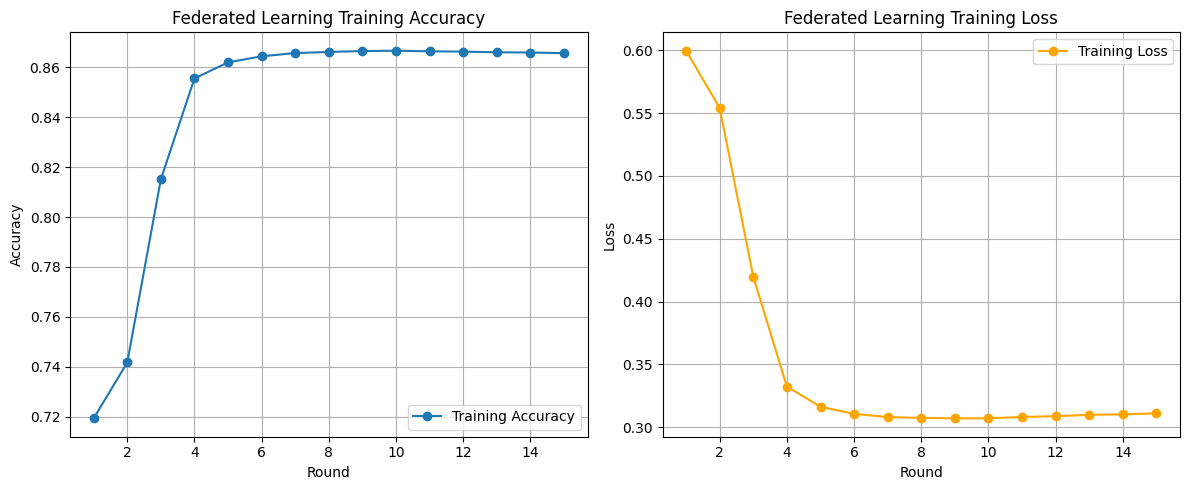

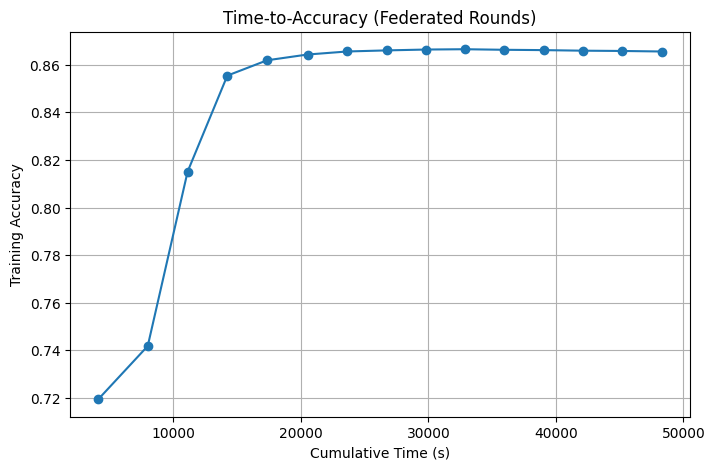


Per-Client Federated Test Metrics:
Client 1 => OrderedDict([('sparse_categorical_accuracy', 0.983298), ('loss', 0.032375224)])
Client 2 => OrderedDict([('sparse_categorical_accuracy', 0.98281276), ('loss', 0.03427336)])
Client 3 => OrderedDict([('sparse_categorical_accuracy', 0.9829698), ('loss', 0.033567116)])
Client 4 => OrderedDict([('sparse_categorical_accuracy', 0.98331195), ('loss', 0.033532694)])
Client 5 => OrderedDict([('sparse_categorical_accuracy', 0.9831864), ('loss', 0.03377048)])


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [1]:
###############################################################################
# STEP 1: IMPORTS AND ENVIRONMENT SETUP
###############################################################################
import os
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

from imblearn.over_sampling import ADASYN

import nest_asyncio
nest_asyncio.apply()  # For notebook/interactive environments
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time  # For time-to-accuracy tracking

import tensorflow as tf
import tensorflow_federated as tff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_score, 
    recall_score, 
    f1_score,
    precision_recall_curve,
    average_precision_score
)
from tensorflow.keras.utils import to_categorical

###############################################################################
# STEP 2: LOAD AND LABEL THE DATASET
###############################################################################
def read_and_label_csv_files(root_dir):
    dataframes = []
    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_path, file_name)
                    df = pd.read_csv(file_path)
                    df['label'] = class_dir
                    dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

root_directory = "dataset"
merged_df = read_and_label_csv_files(root_directory)
print("Step 2: Dataset shape (rows, columns) =", merged_df.shape)
# Optional: Uncomment if you want to see the first few rows
# merged_df.head()

###############################################################################
# STEP 3: ENCODE LABELS AND SELECT FEATURES
###############################################################################
label_encoder = LabelEncoder()
merged_df['label'] = label_encoder.fit_transform(merged_df['label'])
merged_df['label'] = merged_df['label'].astype(int)

X = merged_df.drop(columns=['label'])
y = merged_df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Step 3: Feature matrix shape =", X_scaled.shape)
print("Step 3: Number of classes =", len(np.unique(y)))

###############################################################################
# STEP 4: BALANCE DATA USING ADASYN AND ENSURE EQUAL DISTRIBUTION AMONG CLIENTS
###############################################################################
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
print("Step 4: After train/test split -")
print("       X_train shape =", X_train.shape, "y_train shape =", y_train.shape)
print("       X_test  shape =", X_test.shape,  "y_test  shape =", y_test.shape)

# Apply ADASYN to balance the training data
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Check the new class distribution after balancing
print("Step 4: ADASYN Resampled class distribution:\n", pd.Series(y_resampled).value_counts())
print("Step 4: Resampled dataset shape =", X_resampled.shape)

y_onehot = to_categorical(y_resampled)

# Function to split the balanced data equally among clients
def split_balanced_data(X, y, num_clients):
    combined = list(zip(X, y))
    np.random.shuffle(combined)  # Shuffle to randomize the order
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    # Ensure equal data distribution among clients
    data_per_client = len(X_shuffled) // num_clients
    federated_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
        client_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        federated_data.append(client_data)
    return federated_data

num_clients = 5
federated_data = split_balanced_data(X_resampled, y_resampled, num_clients)
print("Step 4: Created balanced federated data with", num_clients, "clients.")

###############################################################################
# STEP 5: CREATE FEDERATED DATA
###############################################################################
# (Already handled in Step 4 with balanced and equally distributed data)

###############################################################################
# STEP 6: PREPROCESS FEDERATED DATA FOR TRAINING
###############################################################################
def preprocess_federated_data(client_data):
    def map_fn(x, y):
        return (
            tf.cast(tf.reshape(x, (-1, X.shape[1], 1)), tf.float32),
            y
        )
    dataset = tf.data.Dataset.from_tensor_slices((client_data["X"], client_data["y"]))
    return dataset.batch(32).map(map_fn)

federated_train_data = [preprocess_federated_data(cd) for cd in federated_data]
print("Step 6: Prepared federated data (list of batched tf.data.Datasets).")

###############################################################################
# STEP 7: DEFINE THE MODEL (SELF-ATTENTION + CNN) - NO CHANGE IN LAYERS
###############################################################################
def build_self_attention_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    attention_scores = tf.keras.layers.Dense(input_shape[0], activation="softmax", name="attention")(inputs)
    attention_output = tf.keras.layers.Multiply()([inputs, attention_scores])

    x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(attention_output)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

###############################################################################
# STEP 8: TFF MODEL FUNCTION + FEDERATED AVERAGING PROCESS (WITH NEW OPTIMIZERS)
###############################################################################
def model_fn():
    keras_model = build_self_attention_cnn((X.shape[1], 1), len(np.unique(y)))
    input_spec = (
        tf.TensorSpec(shape=(None, X.shape[1], 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
    return tff.learning.from_keras_model(
        keras_model=keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Use Adam optimizer for clients and SGD for server
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
)

###############################################################################
# STEP 9: FEDERATED TRAINING (TIME-TO-ACCURACY ADDED)
###############################################################################
state = iterative_process.initialize()
NUM_ROUNDS = 15
round_metrics = []

time_per_round = []
acc_per_round = []
cumulative_time = 0.0

print("\n       Federated learning start         ")
for round_num in range(1, NUM_ROUNDS + 1):
    start_time = time.time()
    state, metrics = iterative_process.next(state, federated_train_data)
    end_time = time.time()

    round_duration = end_time - start_time
    cumulative_time += round_duration
    time_per_round.append(cumulative_time)

    round_metrics.append(metrics)
    train_acc = metrics['train']['sparse_categorical_accuracy']
    train_loss = metrics['train']['loss']
    acc_per_round.append(train_acc)

    print(f"Round {round_num}, Metrics: {metrics}, Round Duration: {round_duration:.2f}s")

###############################################################################
# STEP 10: TEST DATA PREPARATION
###############################################################################
def evaluate_federated_model(state, federated_test_data):
    evaluation = tff.learning.build_federated_evaluation(model_fn)
    return evaluation(state.model, federated_test_data)

federated_test_data = [preprocess_federated_data({"X": X_test, "y": y_test})]
evaluation_metrics = evaluate_federated_model(state, federated_test_data)
print("\nFederated Evaluation Metrics:", evaluation_metrics)

###############################################################################
# STEP 11: TRAINING ACCURACY/LOSS PLOTS + TIME-TO-ACCURACY
###############################################################################
round_accuracies = [m['train']['sparse_categorical_accuracy'] for m in round_metrics]
round_losses = [m['train']['loss'] for m in round_metrics]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_ROUNDS + 1), round_accuracies, marker='o', label='Training Accuracy')
plt.title('Federated Learning Training Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_ROUNDS + 1), round_losses, marker='o', color='orange', label='Training Loss')
plt.title('Federated Learning Training Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Time-to-Accuracy Plot
plt.figure(figsize=(8,5))
plt.plot(time_per_round, acc_per_round, marker='o')
plt.title("Time-to-Accuracy (Federated Rounds)")
plt.xlabel("Cumulative Time (s)")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()

###############################################################################
# STEP 12: PER-CLIENT FEDERATED EVALUATION
###############################################################################
def prepare_test_data_for_each_client(X_test, y_test, num_clients):
    combined = list(zip(X_test, y_test))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    client_test_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
        c_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        client_test_data.append(c_data)
    return client_test_data

client_test_data = prepare_test_data_for_each_client(X_test, y_test, num_clients)
federated_test_data_by_client = [preprocess_federated_data(d) for d in client_test_data]

eval_comp = tff.learning.build_federated_evaluation(model_fn)
print("\nPer-Client Federated Test Metrics:")
client_scores = []
for i, test_dataset in enumerate(federated_test_data_by_client, start=1):
    metrics_i = eval_comp(state.model, [test_dataset])
    client_scores.append(metrics_i)
    print(f"Client {i} => {metrics_i}")

###############################################################################
# STEP 13: LOCAL EVALUATION (CLASSIFICATION REPORT, CONFUSION MATRIX, ETC.)
###############################################################################
def assign_tff_weights_to_keras(keras_model, tff_state_model):
    # Extract trainable weights from TFF state and assign to Keras model
    # This assumes that the order and shapes of weights match
    keras_model.set_weights([w.numpy() for w in tff_state_model.trainable])

local_keras_model = build_self_attention_cnn(
    input_shape=(X.shape[1], 1),
    num_classes=len(np.unique(y))
)
assign_tff_weights_to_keras(local_keras_model, state.model)
local_keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Full test set predictions (local)
y_pred_probs = local_keras_model.predict(np.expand_dims(X_test, axis=-1))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\n========== Classification Report (Local) ==========")
actual_class_names = label_encoder.classes_
print(classification_report(y_test, y_pred_classes, target_names=actual_class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=actual_class_names,
    yticklabels=actual_class_names
)
plt.title("Confusion Matrix (Global Test Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curves (One-vs-Rest)
num_classes = len(np.unique(y))
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_dict[i] = fpr
    tpr_dict[i] = tpr
    roc_auc_dict[i] = roc_auc

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_dict[i], tpr_dict[i], label=f"{actual_class_names[i]} (AUC = {roc_auc_dict[i]:.2f})")

plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("\n========== All Done! ==========")

###############################################################################
# STEP 14: ADDITIONAL VISUALIZATIONS (MICRO/MACRO PR, CLIENT-SPECIFIC CONFUSION)
###############################################################################
print("\n========== STEP 14: Additional Visualizations ==========")

# 14.1 Micro/Macro PR Curves
precision_micro, recall_micro, _ = precision_recall_curve(y_test_onehot.ravel(), y_pred_probs.ravel())
ap_micro = average_precision_score(y_test_onehot.ravel(), y_pred_probs.ravel())

ap_macro = 0
for i in range(num_classes):
    ap_macro += average_precision_score(y_test_onehot[:, i], y_pred_probs[:, i])
ap_macro /= num_classes

plt.figure(figsize=(8, 6))
plt.plot(recall_micro, precision_micro, label=f"Micro-Avg (AP={ap_micro:.2f})")
plt.title("Micro-Averaged Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()

print(f"Micro-AP: {ap_micro:.2f}, Approx Macro-AP: {ap_macro:.2f}")

# 14.2 Client-Specific Confusion Matrices
def plot_client_confusion_matrices(local_model, client_test_data, label_names):
    for i, c_data in enumerate(client_test_data, start=1):
        y_pred_c = local_model.predict(np.expand_dims(c_data["X"], axis=-1))
        y_pred_classes_c = np.argmax(y_pred_c, axis=1)
        c_mat = confusion_matrix(c_data["y"], y_pred_classes_c)

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            c_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names
        )
        plt.title(f"Confusion Matrix - Client {i}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

print("\n========== Client-Specific Confusion Matrices ==========")
plot_client_confusion_matrices(local_keras_model, client_test_data, actual_class_names)

print("\n========== Additional Visualizations Complete! ==========")



========== Classification Report (Local) ==========
                          precision    recall  f1-score   support

            ARP_Spoofing       0.41      0.56      0.47      3209
                  Benign       0.98      0.84      0.91     38546
               DDoS-ICMP       1.00      1.00      1.00    307495
                DDoS-SYN       1.00      1.00      1.00    160393
                DDoS-TCP       1.00      1.00      1.00    160893
                DDoS-UDP       1.00      1.00      1.00    327191
                DoS-ICMP       0.99      1.00      0.99     83259
                 DoS-SYN       0.99      1.00      1.00     88381
                 DoS-TCP       0.99      1.00      1.00     76077
                 DoS-UDP       1.00      1.00      1.00    113390
 MQTT-DDoS-Connect_Flood       1.00      0.98      0.99     34607
 MQTT-DDoS-Publish_Flood       0.99      1.00      0.99      5525
  MQTT-DoS-Connect_Flood       0.79      0.98      0.87      2555
MQTT-DoS-Published_Flo

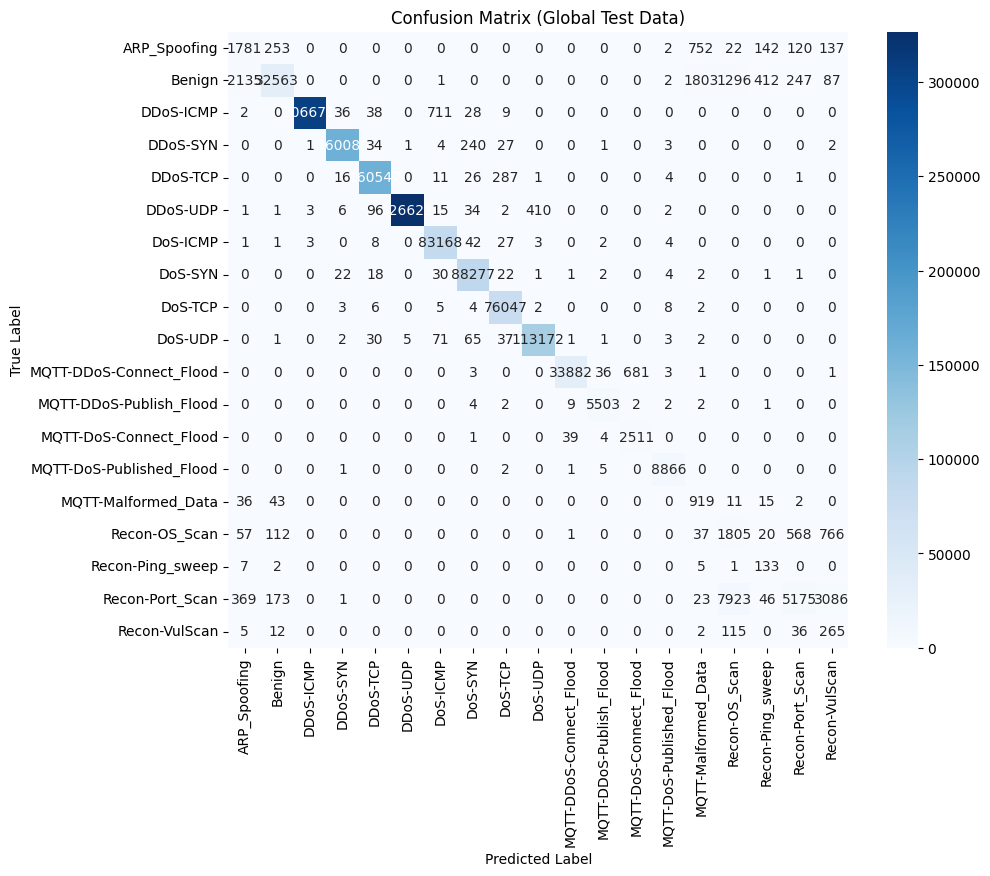

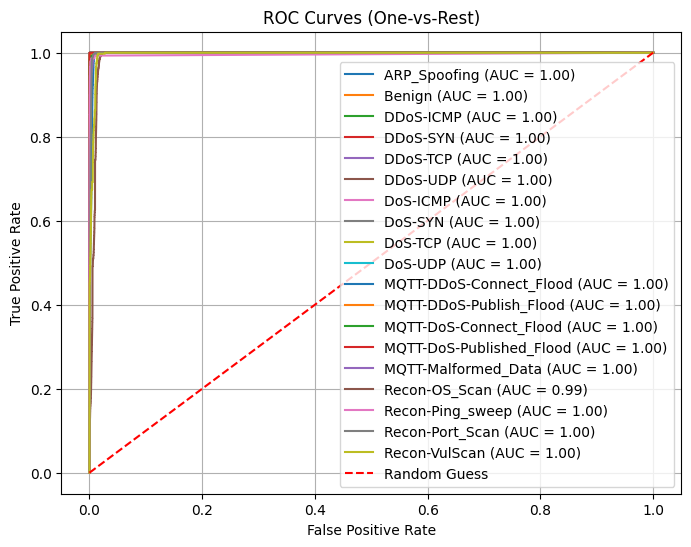


========== STEP 14: Additional Visualizations ==========


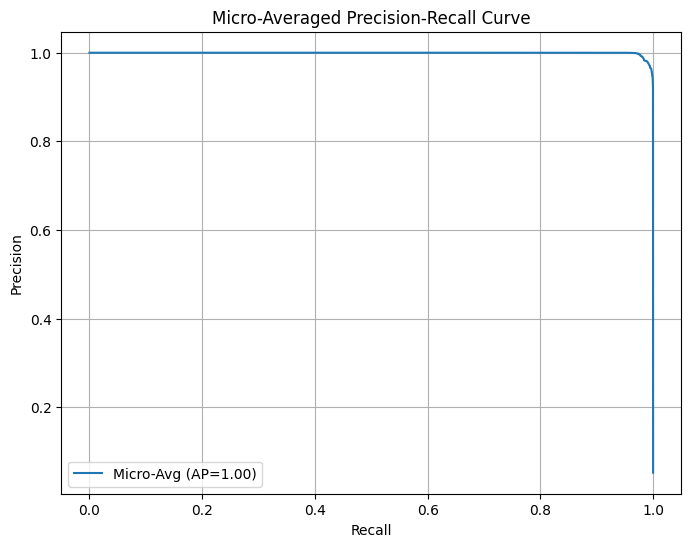

Micro-AP: 1.00, Approx Macro-AP: 0.85

========== Client-Specific Confusion Matrices ==========


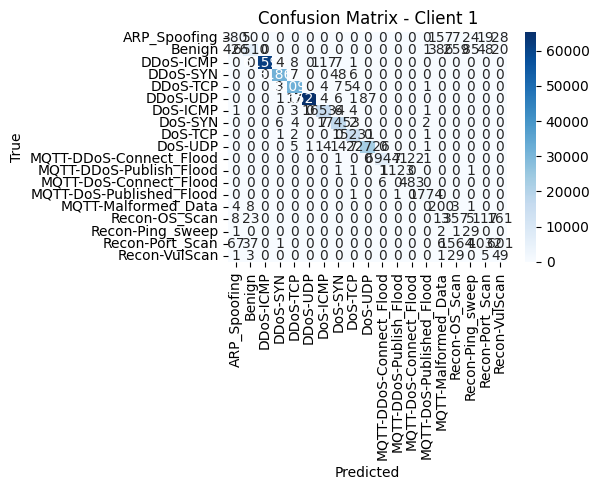

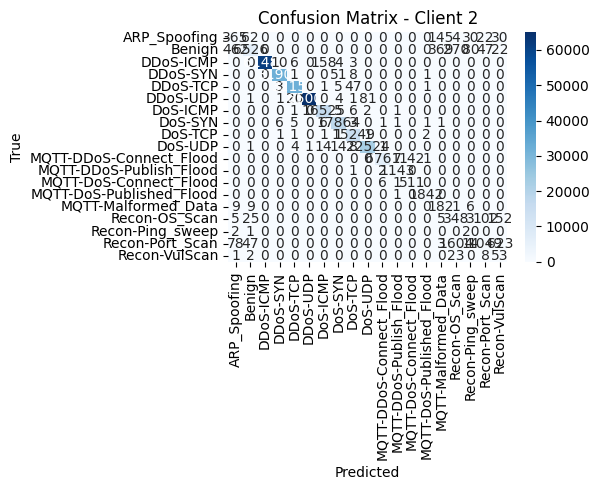

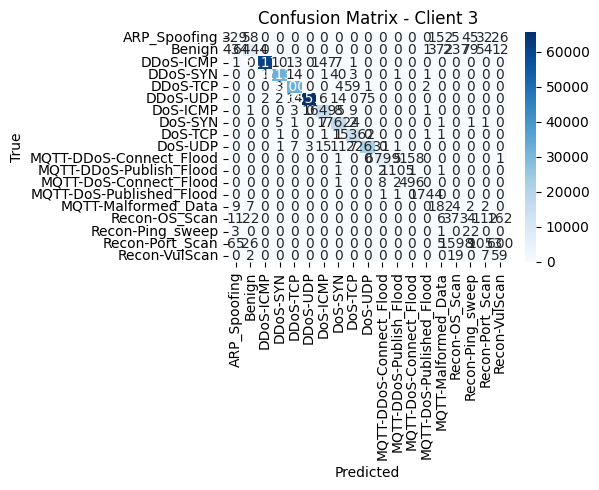

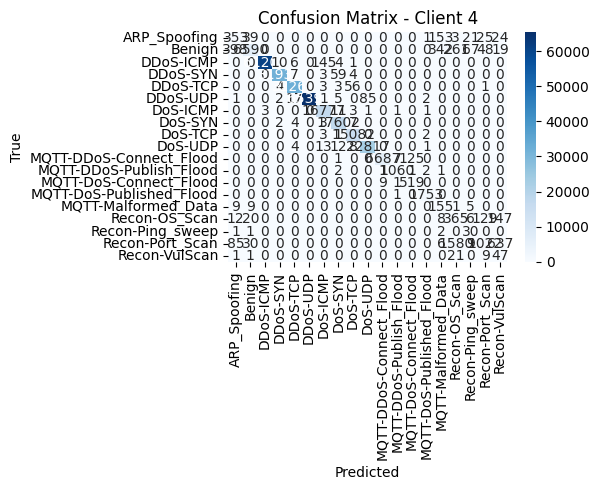

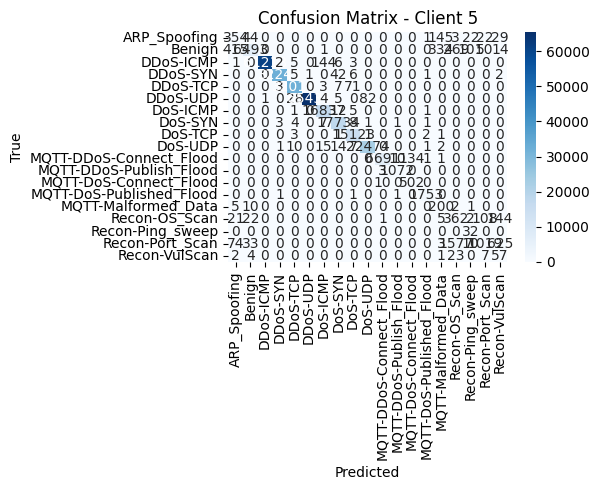


========== Additional Visualizations Complete! ==========

========== All Done! ==========


In [2]:

###############################################################################
# STEP 13: LOCAL EVALUATION (CLASSIFICATION REPORT, CONFUSION MATRIX, ETC.)
###############################################################################
def assign_tff_weights_to_keras(keras_model, tff_state_model):
    # CORRECTED: Directly use trainable weights (already numpy arrays)
    keras_model.set_weights(tff_state_model.trainable)

local_keras_model = build_self_attention_cnn(
    input_shape=(X.shape[1], 1),
    num_classes=len(np.unique(y))
)
assign_tff_weights_to_keras(local_keras_model, state.model)
local_keras_model.compile(optimizer='adam', 
                         loss='sparse_categorical_crossentropy', 
                         metrics=['accuracy'])

# Full test set predictions (local)
y_pred_probs = local_keras_model.predict(np.expand_dims(X_test, axis=-1))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\n========== Classification Report (Local) ==========")
actual_class_names = label_encoder.classes_
print(classification_report(y_test, y_pred_classes, 
                           target_names=actual_class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=actual_class_names,
    yticklabels=actual_class_names
)
plt.title("Confusion Matrix (Global Test Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curves (One-vs-Rest)
num_classes = len(np.unique(y))
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_dict[i] = fpr
    tpr_dict[i] = tpr
    roc_auc_dict[i] = roc_auc

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_dict[i], tpr_dict[i], 
            label=f"{actual_class_names[i]} (AUC = {roc_auc_dict[i]:.2f})")

plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

###############################################################################
# STEP 14: ADDITIONAL VISUALIZATIONS (MICRO/MACRO PR, CLIENT-SPECIFIC CONFUSION)
###############################################################################
print("\n========== STEP 14: Additional Visualizations ==========")

# 14.1 Micro/Macro PR Curves
precision_micro, recall_micro, _ = precision_recall_curve(
    y_test_onehot.ravel(), y_pred_probs.ravel()
)
ap_micro = average_precision_score(y_test_onehot.ravel(), y_pred_probs.ravel())

ap_macro = 0
for i in range(num_classes):
    ap_macro += average_precision_score(y_test_onehot[:, i], y_pred_probs[:, i])
ap_macro /= num_classes

plt.figure(figsize=(8, 6))
plt.plot(recall_micro, precision_micro, label=f"Micro-Avg (AP={ap_micro:.2f})")
plt.title("Micro-Averaged Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()

print(f"Micro-AP: {ap_micro:.2f}, Approx Macro-AP: {ap_macro:.2f}")

# 14.2 Client-Specific Confusion Matrices
def plot_client_confusion_matrices(local_model, client_test_data, label_names):
    for i, c_data in enumerate(client_test_data, start=1):
        y_pred_c = local_model.predict(np.expand_dims(c_data["X"], axis=-1))
        y_pred_classes_c = np.argmax(y_pred_c, axis=1)
        c_mat = confusion_matrix(c_data["y"], y_pred_classes_c)

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            c_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names
        )
        plt.title(f"Confusion Matrix - Client {i}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

print("\n========== Client-Specific Confusion Matrices ==========")
plot_client_confusion_matrices(local_keras_model, client_test_data, actual_class_names)

print("\n========== Additional Visualizations Complete! ==========")
print("\n========== All Done! ==========")

In [6]:
###############################################################################
# STEP 1: IMPORTS AND ENVIRONMENT SETUP
###############################################################################
import os
import warnings
warnings.filterwarnings("ignore")

import nest_asyncio
nest_asyncio.apply()
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

import tensorflow as tf
import tensorflow_federated as tff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import ADASYN

###############################################################################
# HYPERPARAMETERS (ADJUST THESE VALUES)
###############################################################################
CLIENT_LR = 0.001            # [0.0001, 0.001, 0.005]
SERVER_LR = 1.0              # [0.5, 1.0, 2.0]
NUM_ROUNDS = 30              # [15, 30, 50]
BATCH_SIZE = 64              # [32, 64, 128]
CONV_FILTERS = 128           # [64, 128, 256]
DENSE_UNITS = 256            # [128, 256, 512]
DROPOUT_RATE = 0.3           # [0.2, 0.3, 0.5]
USE_FOCAL_LOSS = True        # [True/False]
USE_CLASS_WEIGHTS = False    # [True/False]

###############################################################################
# STEP 2: LOAD AND LABEL THE DATASET
###############################################################################
def read_and_label_csv_files(root_dir):
    dataframes = []
    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_path, file_name)
                    df = pd.read_csv(file_path)
                    df['label'] = class_dir
                    dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

root_directory = "dataset"
merged_df = read_and_label_csv_files(root_directory)

###############################################################################
# STEP 3: ENCODE LABELS AND SELECT FEATURES
###############################################################################
label_encoder = LabelEncoder()
merged_df['label'] = label_encoder.fit_transform(merged_df['label'])
merged_df['label'] = merged_df['label'].astype(int)

X = merged_df.drop(columns=['label'])
y = merged_df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

###############################################################################
# STEP 4: BALANCE DATA USING ADASYN (ORIGINAL IMPLEMENTATION)
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

###############################################################################
# STEP 5: FEDERATED DATA PREPARATION
###############################################################################
def split_balanced_data(X, y, num_clients):
    combined = list(zip(X, y))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    return [
        {"X": X_shuffled[i*data_per_client:(i+1)*data_per_client],
         "y": y_shuffled[i*data_per_client:(i+1)*data_per_client]}
        for i in range(num_clients)
    ]

num_clients = 5
federated_data = split_balanced_data(X_resampled, y_resampled, num_clients)

###############################################################################
# STEP 6: LOSS FUNCTION IMPLEMENTATION
###############################################################################
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        pt = tf.math.exp(-ce)
        return tf.reduce_mean(alpha * (1 - pt)**gamma * ce)
    return loss_fn

loss_fn = focal_loss() if USE_FOCAL_LOSS else tf.keras.losses.SparseCategoricalCrossentropy()

###############################################################################
# STEP 7: MODEL DEFINITION WITH HYPERPARAMETERS
###############################################################################
def build_self_attention_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Attention Mechanism
    attention_scores = tf.keras.layers.Dense(input_shape[0], activation="softmax")(inputs)
    attention_output = tf.keras.layers.Multiply()([inputs, attention_scores])
    
    # Convolutional Block
    x = tf.keras.layers.Conv1D(CONV_FILTERS, 3, activation='relu')(attention_output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    
    # Dense Layers
    x = tf.keras.layers.Dense(DENSE_UNITS, activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
    
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

###############################################################################
# STEP 8: FEDERATED LEARNING SETUP
###############################################################################
def preprocess_federated_data(client_data):
    dataset = tf.data.Dataset.from_tensor_slices(
        (client_data["X"], client_data["y"])
    )
    return dataset.batch(BATCH_SIZE).map(
        lambda x, y: (tf.cast(tf.reshape(x, (-1, X.shape[1], 1)), tf.float32), y)
    )

federated_train_data = [preprocess_federated_data(cd) for cd in federated_data]

def model_fn():
    keras_model = build_self_attention_cnn((X.shape[1], 1), len(np.unique(y)))
    return tff.learning.from_keras_model(
        keras_model=keras_model,
        input_spec=(
            tf.TensorSpec(shape=(None, X.shape[1], 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        ),
        loss=loss_fn,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

iterative_process = tff.learning.build_federated_averaging_process(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(CLIENT_LR),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(SERVER_LR)
)

###############################################################################
# STEP 9: FEDERATED TRAINING
###############################################################################
state = iterative_process.initialize()
round_metrics = []
time_per_round = []
cumulative_time = 0.0

print("\nStarting Federated Training...")
for round_num in range(1, NUM_ROUNDS + 1):
    start_time = time.time()
    state, metrics = iterative_process.next(state, federated_train_data)
    end_time = time.time()
    
    round_duration = end_time - start_time
    cumulative_time += round_duration
    time_per_round.append(cumulative_time)
    
    round_metrics.append(metrics)
    print(f"Round {round_num}/{NUM_ROUNDS} | "
          f"Accuracy: {metrics['train']['sparse_categorical_accuracy']:.4f} | "
          f"Loss: {metrics['train']['loss']:.4f} | "
          f"Time: {round_duration:.2f}s")

###############################################################################
# STEP 10: EVALUATION AND VISUALIZATION
###############################################################################
# Model Weight Assignment
local_model = build_self_attention_cnn((X.shape[1], 1), len(np.unique(y)))
local_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
local_model.set_weights(state.model.trainable)

# Test Set Evaluation
y_pred_probs = local_model.predict(np.expand_dims(X_test, axis=-1))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                           target_names=label_encoder.classes_,
                           zero_division=0))

# Confusion Matrix
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Training Metrics Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([m['train']['sparse_categorical_accuracy'] for m in round_metrics])
plt.title("Training Accuracy")
plt.xlabel("Round")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot([m['train']['loss'] for m in round_metrics], color='orange')
plt.title("Training Loss")
plt.xlabel("Round")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

print("\nTraining Complete!")

MemoryError: Unable to allocate 67.6 MiB for an array with shape (45, 196880) and data type float64